In [2]:
import numpy as np
import os
import matplotlib
from pathlib import Path
import pylab as pl
from tifffile import imsave, imread
import gzip
import pickle
from scipy.stats import ttest_ind, ttest_1samp
from scipy.stats import linregress
from scipy import stats
from sklearn.cluster import KMeans
import seaborn as sns
import pandas as pd
import math

import matplotlib.pyplot as plt
import matplotlib.patches as patches

(653, 389)


/Users/danielbarabasi/opt/anaconda3/envs/OMR/lib/python3.9/site-packages/numpy/core/fromnumeric.py:2007: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape
/Users/danielbarabasi/opt/anaconda3/envs/OMR/lib/python3.9/site-packages/numpy/core/fromnumeric.py:2007: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


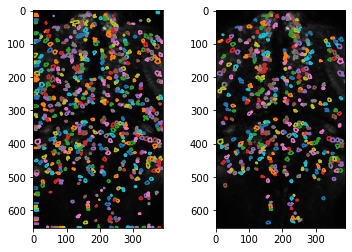

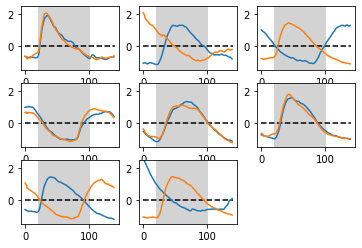

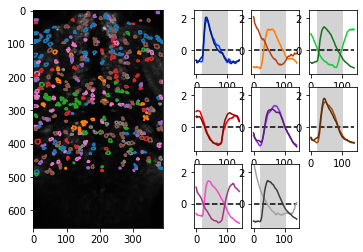

In [22]:






#fish_path = Path("/Volumes/BigFishThry/GoodGregor2P/LifetimeTricaine/Feb17_LargeLong/2022-02-17_17-13-28/rawdata")
#fish_path = Path("/Volumes/BigFishThry/GoodGregor2P/SpotTricaine/Jan19_LargeLong/2022-01-19_12-27-47/rawdata")
fish_path = Path("/Volumes/BigFishThry/GoodGregor2P/ControlFish/Feb22/2022-02-22_14-12-50/rawdata")

file = str(fish_path)+'/z_plane0000_trial000_trials_stimulus_aligned_C.pickle'
trials_stimulus_aligned_C = pickle.load(open(file, 'rb'))


z_plane = 0 # 7         # Set this according to file name?
trial = 0               # Set this according to file name?

####################################
# Load the calcium trace matrix and calculate C-C0

clusters = 8



#                                               Baseline correction
# ======================================================================================================================
# for each cell, measure the baseline C in a 10 sec window right before stimulus onset (20 - 40, i.e. 10 to 20 sec sampled at 2 Hz)
# for each cell, subtract this baseline measurement from all its C values
# function used is A -= B, i.e. A = A - B, so the 'trials_stimulus_aligned_C' gets over-written!

for stim_key in trials_stimulus_aligned_C.keys():       # 0 or 1 -> loop through stimulus types (left or right)
    for trial_n in range(np.shape(trials_stimulus_aligned_C[stim_key])[0]): # loop through the trials (e.g. 28 trials to left)
        for unit_i in range(np.shape(trials_stimulus_aligned_C[stim_key])[1]): # loop through the cells
            trials_stimulus_aligned_C[stim_key][trial_n][unit_i] -= \
                np.nanmean(trials_stimulus_aligned_C[stim_key][trial_n][unit_i][int(10/0.5):int(20/0.5)])





#                                   Load the background image and make it 8 bit
# ======================================================================================================================

temporal_average = imread(os.path.join(fish_path,
                                       "z_plane0000_trial000_imaging_roi00_green_channel_motion_corrected.tif".format(
                                           z_plane)))



# conversion from 16 bit to 8 bit:
temporal_average = np.array(temporal_average * (np.power(2,8) / np.power(2,16)))
# -> use full range: subtract min, divide max, multiply by 256, convert in float first
# could do better in Fiji and load into Pycharm
temporal_average[temporal_average < 0] = 0
temporal_average[temporal_average > 255] = 255
temporal_average = np.array(temporal_average, dtype=np.uint8)
temporal_average = temporal_average.mean(0)
print(temporal_average.shape)


# unit_contours = stimulus_aligned_z_planes_matrices["unit_contours"]
unit_contours = pickle.load(open(fish_path / f'z_plane{z_plane:04d}_trial{trial:03d}_contours.pickle', 'rb'))




### optimize background image, such that 5% and 95% percentiles make up the min and max, respectively



#                                   Determine the 'responsiveness' of cells
# ======================================================================================================================

# split up 'trials_stimulus_aligned_C' into left and right trials and make into numpy arrays for easier indexing
left_trials = np.array(trials_stimulus_aligned_C[0])
right_trials = np.array(trials_stimulus_aligned_C[1])
cell_infos = []

for unit_i in range(np.shape(unit_contours)[0]):
    x, y = np.nanmean(unit_contours[unit_i], axis=0) # get the centroid of the contours

    # for each cell, generate average response to left and right motion across all respective trials, then search for the absolute of the max activity
    # -> readout for how much a cell responds to respective motion

    responsiveness_left = np.abs(np.nanmean(left_trials[:,unit_i,20:160], axis=0)).max() # is the cell doing anything after baseline subtraction??
    responsiveness_right = np.abs(np.nanmean(right_trials[:,unit_i,20:160], axis=0)).max()

    # for each cell, save its centroid's x and y position and its max responsiveness to left and right motion
    cell_infos.append([x, y, responsiveness_left, responsiveness_right])

cell_infos = np.array(cell_infos)


# Plot all cells above a certain threshold for responsiveness left or right (e.g. 200)





#                                          run the K MEANS CLUSTERING
# ======================================================================================================================

# 340 -> image is 700x700 -> cells on left have x < 350, cells on right > 350
# find cells in left hemisphere(x < 340) AND left responsiveness


ind_selected = np.where(((cell_infos[:,3] > 200) | (cell_infos[:,2] > 200)) & (cell_infos[:,0] > 10) & (cell_infos[:,0] < temporal_average.shape[1]-10) & (cell_infos[:,1] > 10) & (cell_infos[:,1] < temporal_average.shape[0]-10)&(np.std(np.nanmean(trials_stimulus_aligned_C[0], axis=0)[:][:, 20:160], axis=1)>0)&(np.std(np.nanmean(trials_stimulus_aligned_C[1], axis=0)[:][:, 20:160], axis=1)>0)) # 200 is arbitrary threshold for responsiveness
# for all cells, average all left trials, then select the left-responsive cells, and select time 20 - 160
left_cells_response_left = np.nanmean(trials_stimulus_aligned_C[0], axis=0)[ind_selected][:, 20:160] # average across trials all le cells
# normalize the response of each cell, such that it has mean of 1 and SD of 1
# -> subtract mean and devide by SD; axis 1 = time axis -> mean and SD over time, so each cell after scaling has mean 1 and Sd 1
# -> keepdims -> keep the matrix as 2D -> diff to Matlab!
# => all cells are scaled with respect to themselves, so different response amplitudes across cells are lost
left_cells_response_left_scaled = (left_cells_response_left -
                              np.mean(left_cells_response_left, axis=1, keepdims=True)) / \
                              np.std(left_cells_response_left, axis=1, keepdims=True)

right_cells_response_right = np.nanmean(trials_stimulus_aligned_C[1], axis=0)[ind_selected][:, 20:160]
right_cells_response_right_scaled = (right_cells_response_right -
                              np.mean(right_cells_response_right, axis=1, keepdims=True)) / \
                              np.std(right_cells_response_right, axis=1, keepdims=True)

meshed_data = np.concatenate((left_cells_response_left_scaled,right_cells_response_right_scaled),axis=1)

# look into this, n clusters needs to be estimated, how are results with different numbers of clusters?
left_cells_response_left_kmeans = KMeans(n_clusters=clusters, random_state=0).fit(meshed_data)

# all cells get label from 0 to 4, whats the mean of the cells response for each of the 5 dynamics
left_cells_response_left_cluster_means = [left_cells_response_left_scaled[left_cells_response_left_kmeans.labels_ == i].mean(axis=0) for i in range(clusters)]
right_cells_response_right_cluster_means = [right_cells_response_right_scaled[left_cells_response_left_kmeans.labels_ == i].mean(axis=0) for i in range(clusters)]


# -------------------------------
# Plot Cells that Passed Threshold
# -------------------------------

pl.figure()
pl.subplot(1,2,1)
pl.imshow(temporal_average, cmap='gray')

# # Plot All Cells
for unit_i in range(np.shape(unit_contours)[0]):
    pl.plot(unit_contours[unit_i][:,0], unit_contours[unit_i][:,1])

pl.subplot(1,2,2)
pl.imshow(temporal_average, cmap='gray')
# # Plot active cells
for unit_i in ind_selected[0]:
    pl.plot(unit_contours[unit_i][:,0], unit_contours[unit_i][:,1])
pl.show()


# ------ plot average curves ------
pl.figure()

for i in range(clusters):
    ax = pl.subplot(3,3,i+1)
    ax.add_patch(patches.Rectangle((20, -2), 80, 50000, edgecolor='lightgrey', facecolor='lightgrey', fill=True))
    plt.plot([0, 140], [0, 0], linestyle='--', color='black')
    pl.plot(left_cells_response_left_cluster_means[i])
    pl.plot(right_cells_response_right_cluster_means[i])
    pl.ylim([-1.5,2.5])

pl.show()


#                                          define the REGRESSORS
# ======================================================================================================================
regressors_left = []
regressors_right = []


# order of regressors from kmeans clustering is random, so they need to be sorted between left and right hemisphere
# -> need to find corresponding partners on both sides
for i in range(clusters):
    # append the respective left regressor
    regressors_left.append(left_cells_response_left_cluster_means[i]) # order of the left regressors remains the same
    # append the right regressor that matches that left regressor best
    regressors_right.append(right_cells_response_right_cluster_means[i]) # right regressors gets sorted with respect to similarity with left regressor




regressors_left = np.array(regressors_left)
regressors_right = np.array(regressors_right)
regressors = np.concatenate((regressors_left, regressors_right),axis = 1) # append left and right regressors

# ## Save the 'interesting' regressors
# # ----------------------------------
# selected_regressors = regressors[[0, 2, 4]] # 0 was motor command, 2 was integrator, 4 was dynamic threshold
# # path = os.path.join(root_path, experiment_name, "regressors.npy")

# path = os.path.join(fish_path, "regressors.npy")

# print(selected_regressors.shape)
# np.save(path, selected_regressors)


# # => regressors were found in only 1 fish, and then used on all other fish!!!!








#                                          REGRESSOR ANALYSIS ON ALL CELLS
# ======================================================================================================================


units_cluster_IDs = []
for unit_i in ind_selected[0]:

    x, y = np.nanmean(unit_contours[unit_i], axis=0)

#   cell_response = np.nanmean(trials_stimulus_aligned_C[0][:][unit_i][20:160], axis=1) # average response of that cell across all traces
    cell_response = np.concatenate((np.nanmean(left_trials[:,unit_i,20:160], axis=0, keepdims=True), np.nanmean(right_trials[:,unit_i,20:160], axis=0, keepdims=True)),axis = 1)
    ci = [np.corrcoef(cell_response, regressors[i])[0, 1] for i in range(clusters)]

    i_max = np.argmax(ci)

    if ci[i_max] > 0.5:
        units_cluster_IDs.append(i_max)
    else:
        units_cluster_IDs.append(-1) # does not belong to any cluster
units_cluster_IDs = np.array(units_cluster_IDs)



#                                      LABEL CELLS FOUND WITH REGRESSOR ANALYSIS
# ======================================================================================================================
pl.figure()
ax = pl.subplot(1,2,1)
pl.imshow(temporal_average, cmap='gray')
# Plot the regressors
for unit_i,id in enumerate(ind_selected[0]):

    if units_cluster_IDs[unit_i] > -1:
        pl.plot(unit_contours[unit_i][:,0], unit_contours[unit_i][:,1], color=sns.color_palette()[units_cluster_IDs[unit_i]])


for i in range(clusters):
    ax = pl.subplot(3,6,i+3*(i//3)+4)
    ax.add_patch(patches.Rectangle((20, -2), 80, 50000, edgecolor='lightgrey', facecolor='lightgrey', fill=True))
    plt.plot([0, 140], [0, 0], linestyle='--', color='black')
    pl.plot(left_cells_response_left_cluster_means[i],color=sns.color_palette("bright")[i])
    pl.plot(right_cells_response_right_cluster_means[i],color=sns.color_palette("dark")[i])
    pl.ylim([-1.5,2.5])
pl.show()

# Plot Cell Locations

## Process and Save Lifetime Data

In [4]:
from lib2to3.pytree import Base
import numpy as np
import os
import matplotlib
from pathlib import Path
import pylab as pl
from tifffile import imsave, imread
import gzip
import pickle
from scipy.stats import ttest_ind, ttest_1samp
from scipy.stats import linregress
from scipy import stats
from sklearn.cluster import KMeans
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.patches as patches


def LoadData(NewPath):
 
    fish_path = NewPath

    file = str(fish_path)+'/z_plane0000_trial000_trials_stimulus_aligned_C.pickle'
    trials_stimulus_aligned_C = pickle.load(open(file, 'rb'))



    z_plane = 0 # 7         # Set this according to file name?
    trial = 0               # Set this according to file name?
    unit_contours = pickle.load(open(fish_path / f'z_plane{z_plane:04d}_trial{trial:03d}_contours.pickle', 'rb'))



    #                                               Baseline correction
    # ======================================================================================================================
    # for each cell, measure the baseline C in a 10 sec window right before stimulus onset (20 - 40, i.e. 10 to 20 sec sampled at 2 Hz)
    # for each cell, subtract this baseline measurement from all its C values
    # function used is A -= B, i.e. A = A - B, so the 'trials_stimulus_aligned_C' gets over-written!

    for stim_key in trials_stimulus_aligned_C.keys():       # 0 or 1 -> loop through stimulus types (left or right)
        for trial_n in range(np.shape(trials_stimulus_aligned_C[stim_key])[0]): # loop through the trials (e.g. 28 trials to left)
            for unit_i in range(np.shape(trials_stimulus_aligned_C[stim_key])[1]): # loop through the cells
                trials_stimulus_aligned_C[stim_key][trial_n][unit_i] -= \
                    np.nanmean(trials_stimulus_aligned_C[stim_key][trial_n][unit_i][int(10/0.5):int(20/0.5)])

    #                                   Determine the 'responsiveness' of cells
    # ======================================================================================================================

    # split up 'trials_stimulus_aligned_C' into left and right trials and make into numpy arrays for easier indexing
    left_trials = np.array(trials_stimulus_aligned_C[0])
    right_trials = np.array(trials_stimulus_aligned_C[1])
    cell_infos = []

    for unit_i in range(np.shape(unit_contours)[0]):
        x, y = np.nanmean(unit_contours[unit_i], axis=0) # get the centroid of the contours

        # for each cell, generate average response to left and right motion across all respective trials, then search for the absolute of the max activity
        # -> readout for how much a cell responds to respective motion

        responsiveness_left = np.abs(np.nanmean(left_trials[:,unit_i,20:160], axis=0)).max() # is the cell doing anything after baseline subtraction??
        responsiveness_right = np.abs(np.nanmean(right_trials[:,unit_i,20:160], axis=0)).max()

        # for each cell, save its centroid's x and y position and its max responsiveness to left and right motion
        cell_infos.append([x, y, responsiveness_left, responsiveness_right])

    cell_infos = np.array(cell_infos)

    temporal_average = imread(os.path.join(fish_path,
                                       "z_plane0000_trial000_imaging_roi00_green_channel_motion_corrected.tif".format(
                                           z_plane)))
    # conversion from 16 bit to 8 bit:
    temporal_average = np.array(temporal_average * (np.power(2,8) / np.power(2,16)))
    # -> use full range: subtract min, divide max, multiply by 256, convert in float first
    # could do better in Fiji and load into Pycharm
    temporal_average[temporal_average < 0] = 0
    temporal_average[temporal_average > 255] = 255
    temporal_average = np.array(temporal_average, dtype=np.uint8)
    temporal_average = temporal_average.mean(0)

    ind_selected = np.where(((cell_infos[:,3] > 200) | (cell_infos[:,2] > 200)) & (cell_infos[:,0] > 10) & (cell_infos[:,0] < temporal_average.shape[1]-10) & (cell_infos[:,1] > 10) & (cell_infos[:,1] < temporal_average.shape[0]-10)&(np.std(np.nanmean(trials_stimulus_aligned_C[0], axis=0)[:][:, 20:160], axis=1)>0)&(np.std(np.nanmean(trials_stimulus_aligned_C[1], axis=0)[:][:, 20:160], axis=1)>0)) # 200 is arbitrary threshold for responsiveness
    return left_trials, right_trials, ind_selected, unit_contours




In [5]:
BasePath_1 =  "/Volumes/BigFishThry/GoodGregor2P/LifetimeTricaine/"
Fish = 'Feb17_LargeLong'
BasePath = BasePath_1 + Fish + '/'


z_plane = 0 # 7         # Set this according to file name?
trial = 0               # Set this according to file name?

files = [i for i in os.listdir(BasePath) if "2022" in i]
files.sort()

fish_path = Path(BasePath + files[0] + "/rawdata")


PlottingContours = {}
# conversion from 16 bit to 8 bit:
CellTypeCountsMeta = np.empty((0,clusters))
for file in files:
    left_trials,right_trials,ind_selected, unit_contours = LoadData(Path(BasePath+file+"/rawdata"))
    units_cluster_IDs = []
    for unit_i in ind_selected[0]:
        cell_response = np.concatenate((np.nanmean(left_trials[:,unit_i,20:160], axis=0, keepdims=True), np.nanmean(right_trials[:,unit_i,20:160], axis=0, keepdims=True)),axis = 1)
        ci = [np.corrcoef(cell_response, regressors[i])[0, 1] for i in range(clusters)]

        i_max = np.argmax(ci)

        if ci[i_max] > 0.5:
            units_cluster_IDs.append(i_max)
        else:
            units_cluster_IDs.append(-1) # does not belong to any cluster
    # Plot the regressors
    Lefts = [[],[]]
    Ons = [[],[]]
    Rights = [[],[]]
    for unit_i,id in enumerate(ind_selected[0]):
        if units_cluster_IDs[unit_i] in [1,6]:
            Lefts[0] = Lefts[0] + [np.nanmean(unit_contours[unit_i][:,0])]
            Lefts[1] = Lefts[1] + [np.nanmean(unit_contours[unit_i][:,1])]
        elif units_cluster_IDs[unit_i] in [0,4,5]:
            Ons[0] = Ons[0] + [np.nanmean(unit_contours[unit_i][:,0])]
            Ons[1] = Ons[1] + [np.nanmean(unit_contours[unit_i][:,1])]
        elif units_cluster_IDs[unit_i] in [2,7]:
            Rights[0] = Rights[0] + [np.nanmean(unit_contours[unit_i][:,0])]
            Rights[1] = Rights[1] + [np.nanmean(unit_contours[unit_i][:,1])]
    PlottingContours[file] = {"Lefts": Lefts, "Ons": Ons, "Rights": Rights}

/Users/danielbarabasi/opt/anaconda3/envs/OMR/lib/python3.9/site-packages/numpy/core/fromnumeric.py:2007: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


In [6]:
with open('PlottingLifetimeContours.pickle', 'wb') as handle:
    pickle.dump(PlottingContours, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Plot Data

In [ ]:
with open('PlottingContours.pickle', 'rb') as handle:
    PlottingContours = pickle.load(handle)

BasePath_1 =  "/Volumes/BigFishThry/GoodGregor2P/SpotTricaine/"
Fish = 'Jan19_LargeLong'
BasePath = BasePath_1 + Fish + '/'


z_plane = 0 # 7         # Set this according to file name?
trial = 0               # Set this according to file name?

files = [i for i in os.listdir(BasePath) if "2022" in i]
files.sort()

sizes = 5
alphas = 1

values = [40,32,37,37,20,35]
for vals,file in enumerate(files):
    
    # fish_path = Path(BasePath + file + "/rawdata")

    # temporal_average = imread(os.path.join(fish_path,
    #                                     "z_plane0000_trial000_imaging_roi00_green_channel_motion_corrected_avg_response1.tif".format(
    #                                         z_plane)))

    # temporal_average = np.array(temporal_average * (np.power(2,8) / np.power(2,16)))
    # # -> use full range: subtract min, divide max, multiply by 256, convert in float first
    # # could do better in Fiji and load into Pycharm
    # temporal_average[temporal_average < 0] = 0
    # temporal_average[temporal_average > 255] = 255
    # temporal_average = np.array(temporal_average, dtype=np.uint8)
    # temporal_average = temporal_average.mean(0)
    # temportal_average_new = 255*temporal_average / np.max(temporal_average)
    # value = values[vals]
    # temportal_average_new = np.where((255 - temportal_average_new) < value,255,temportal_average_new+value)
    temporal_average = imread('/Volumes/BigFishThry/GoodGregor2P/SpotTricaine/Jan19_LargeLong/2021-01-19-tectumhindbrain/AVG_hour'+str(vals+1)+'.tif')
    pl.figure(dpi=600)
    ax = pl.subplot(1,2,1)
    pl.imshow(temporal_average, cmap='gray')
        # Plot the regressors
    pl.scatter(PlottingContours[file]['Lefts'][0],PlottingContours[file]['Lefts'][1], color=sns.color_palette()[1], s= sizes, alpha = alphas)
    pl.scatter(PlottingContours[file]['Ons'][0],PlottingContours[file]['Ons'][1], color=sns.color_palette()[0], s= sizes, alpha = alphas)
    pl.scatter(PlottingContours[file]['Rights'][0],PlottingContours[file]['Rights'][1], color=sns.color_palette()[3], s= sizes, alpha = alphas)
    pl.xticks([])
    pl.yticks([])
    pl.savefig('Figures/Figure4/'+Fish+file+'.pdf',bbox_inches='tight') 

In [ ]:
with open('PlottingLifetimeContours.pickle', 'rb') as handle:
    PlottingContours = pickle.load(handle)

BasePath_1 =  "/Volumes/BigFishThry/GoodGregor2P/LifetimeTricaine/"
Fish = 'Feb17_LargeLong'
BasePath = BasePath_1 + Fish + '/'


z_plane = 0 # 7         # Set this according to file name?
trial = 0               # Set this according to file name?

files = [i for i in os.listdir(BasePath) if "2022" in i]
files.sort()

sizes = 5
alphas = 1
values = [5,55,50,40]
for vals,file in enumerate(files):
    
    # fish_path = Path(BasePath + file + "/rawdata")
    # if vals > 0:
    #     temporal_average = imread(os.path.join(fish_path,
    #                                         "z_plane0000_trial000_imaging_roi00_green_channel_motion_corrected_avg_response1.tif".format(
    #                                             z_plane)))
    # else:
    #     temporal_average = imread(os.path.join(fish_path,
    #                                         "z_plane0000_trial000_imaging_roi00_green_channel_motion_corrected.tif".format(
    #                                             z_plane)))
    # temporal_average = np.array(temporal_average * (np.power(2,8) / np.power(2,16)))
    # # -> use full range: subtract min, divide max, multiply by 256, convert in float first
    # # could do better in Fiji and load into Pycharm
    # temporal_average[temporal_average < 0] = 0
    # temporal_average[temporal_average > 255] = 255
    # temporal_average = np.array(temporal_average, dtype=np.uint8)
    # temporal_average = temporal_average.mean(0)
    # temportal_average_new = 255*temporal_average / np.max(temporal_average)
    # value = values[vals]
    # temportal_average_new = np.where((255 - temportal_average_new) < value,255,temportal_average_new+value)
    temporal_average_new = imread('/Volumes/BigFishThry/GoodGregor2P/LifetimeTricaine/Feb17_LargeLong/Feb17-4hrsSmall/AVG_'+str(vals+1)+'hr.tif')
    pl.figure(dpi = 600)
    ax = pl.subplot(1,2,1)
    pl.imshow(temporal_average_new, cmap='gray')
        # Plot the regressors
    pl.scatter(PlottingContours[file]['Lefts'][0],PlottingContours[file]['Lefts'][1], color=sns.color_palette()[1], s= sizes, alpha = alphas)
    pl.scatter(PlottingContours[file]['Ons'][0],PlottingContours[file]['Ons'][1], color=sns.color_palette()[0], s= sizes, alpha = alphas)
    pl.scatter(PlottingContours[file]['Rights'][0],PlottingContours[file]['Rights'][1], color=sns.color_palette()[3], s= sizes, alpha = alphas)
    pl.xticks([])
    pl.yticks([])
    pl.savefig('Figures/Figure4/'+Fish+file+'.pdf',bbox_inches='tight') 

# Number of Cells Over Time
data generated from FindRegressorAndFit_plotting

In [2]:
with open('Figures/Figure3/NumberCellTypes_filter17', 'rb') as file:
    DataDict,left_cells_response_left_cluster_means,right_cells_response_right_cluster_means = pickle.load(file)


In [5]:
DataDict.keys()

dict_keys(['LifetimeTricaine_Feb17_LargeLong', 'LifetimeTricaine_Feb15', 'LifetimeTricaine_Feb16', 'ControlFish_Feb22', 'ControlFish_Mar1', 'SpotTricaine_Jan19_LargeLong', 'SpotTricaine_Jan7', 'SpotTricaine_Jan5'])

{'Lifetime1': [0, 1.0, 107.0, 115.0, 90.0],
 'Lifetime2': [0, 3.0, 68.0, 164.0, 173.0],
 'Lifetime3': [0, 0.0, 47.0, 95.0, 54.0, 62.0],
 'Control1': [249.0, 197.0, 216.0, 191.0],
 'Control2': [137.0, 129.0, 170.0, 151.0],
 'Spot1': [192.0, 3.0, 85.0, 100.0, 110.0, 161.0],
 'Spot2': [72.0, 1.0, 1.0, 6.0],
 'Spot3': [228.0, 26.0, 103.0, 154.0, 181.0]}

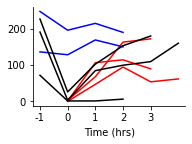

In [12]:
df = {}
# On, left and right Cells
life_iter = 1
control_iter = 1
spot_iter = 1
ax = plt.subplot(2,2,1)
for key in DataDict:
    if key.split('_')[0] == 'LifetimeTricaine':
        
        plot_val = DataDict[key][:,0] + DataDict[key][:,4] + DataDict[key][:,5] + DataDict[key][:,2] + DataDict[key][:,6]
        df['Lifetime'+str(life_iter)] = [0] + list(plot_val)
        plt.plot(1+np.array(range(DataDict[key].shape[0])),plot_val,'r')
        life_iter = life_iter+1
        
    elif key.split('_')[0] == 'ControlFish':
        plot_val = DataDict[key][:,0] + DataDict[key][:,4] + DataDict[key][:,5]+ DataDict[key][:,2] + DataDict[key][:,6]
        df['Control'+str(control_iter)] = list(plot_val)
        plt.plot(plot_val,'b')
        control_iter = control_iter + 1
    else: 
        plot_val = DataDict[key][:,0] + DataDict[key][:,4] + DataDict[key][:,5]+ DataDict[key][:,2] + DataDict[key][:,6]
        plt.plot(plot_val,'k')
        df['Spot'+str(spot_iter)] = list(plot_val)
        spot_iter = spot_iter + 1
plt.xticks([])
for bounds in ['right','top']:
    right_side = ax.spines[bounds]
    right_side.set_visible(False)
    right_side = ax.spines[bounds]
    right_side.set_visible(False)

plt.xticks([0,1,2,3,4])
ax.set(xticklabels = [-1,0,1,2,3])
plt.xlabel('Time (hrs)')
plt.savefig('Figures/Figure4/CellTypesFitted.pdf',bbox_inches='tight') 
df

{'Lifetime1': [0, 0.0, 88.0, 87.0, 78.0],
 'Lifetime2': [0, 2.0, 58.0, 159.0, 153.0],
 'Lifetime3': [0, 0.0, 46.0, 94.0, 46.0, 52.0],
 'Control1': [175.0, 132.0, 142.0, 116.0],
 'Control2': [94.0, 87.0, 106.0, 94.0],
 'Spot1': [138.0, 1.0, 62.0, 79.0, 90.0, 133.0],
 'Spot2': [62.0, 1.0, 0.0, 4.0],
 'Spot3': [188.0, 18.0, 81.0, 131.0, 157.0]}

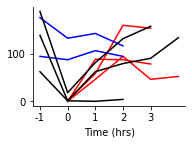

In [3]:
df = {}
# On Cells
life_iter = 1
control_iter = 1
spot_iter = 1
ax = plt.subplot(2,2,1)
for key in DataDict:
    if key.split('_')[0] == 'LifetimeTricaine':
        
        plot_val = DataDict[key][:,0] + DataDict[key][:,4] + DataDict[key][:,5] 
        df['Lifetime'+str(life_iter)] = [0] + list(plot_val)
        plt.plot(1+np.array(range(DataDict[key].shape[0])),plot_val,'r')
        life_iter = life_iter+1
        
    elif key.split('_')[0] == 'ControlFish':
        plot_val = DataDict[key][:,0] + DataDict[key][:,4] + DataDict[key][:,5]
        df['Control'+str(control_iter)] = list(plot_val)
        plt.plot(plot_val,'b')
        control_iter = control_iter + 1
    else: 
        plot_val = DataDict[key][:,0] + DataDict[key][:,4] + DataDict[key][:,5]
        plt.plot(plot_val,'k')
        df['Spot'+str(spot_iter)] = list(plot_val)
        spot_iter = spot_iter + 1
plt.xticks([])
for bounds in ['right','top']:
    right_side = ax.spines[bounds]
    right_side.set_visible(False)
    right_side = ax.spines[bounds]
    right_side.set_visible(False)

plt.xticks([0,1,2,3,4])
ax.set(xticklabels = [-1,0,1,2,3])
plt.xlabel('Time (hrs)')
#plt.savefig('Figures/Figure4/CellTypesFitted.pdf',bbox_inches='tight') 
df

{'Lifetime1': [0, 1.0, 15.0, 10.0, 8.0],
 'Lifetime2': [0, 0.0, 6.0, 2.0, 12.0],
 'Lifetime3': [0, 0.0, 0.0, 1.0, 6.0, 6.0],
 'Control1': [38.0, 32.0, 40.0, 33.0],
 'Control2': [30.0, 12.0, 21.0, 31.0],
 'Spot1': [32.0, 2.0, 18.0, 15.0, 16.0, 17.0],
 'Spot2': [2.0, 0.0, 0.0, 1.0],
 'Spot3': [27.0, 0.0, 9.0, 13.0, 14.0]}

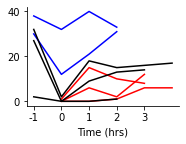

In [9]:
df = {}
# Left Cells
life_iter = 1
control_iter = 1
spot_iter = 1
ax = plt.subplot(2,2,1)
for key in DataDict:
    if key.split('_')[0] == 'LifetimeTricaine':
        
        plot_val = DataDict[key][:,6] 
        df['Lifetime'+str(life_iter)] = [0] + list(plot_val)
        plt.plot(1+np.array(range(DataDict[key].shape[0])),plot_val,'r')
        life_iter = life_iter+1
        
    elif key.split('_')[0] == 'ControlFish':
        plot_val = DataDict[key][:,6] 
        df['Control'+str(control_iter)] = list(plot_val)
        plt.plot(plot_val,'b')
        control_iter = control_iter + 1
    else: 
        plot_val = DataDict[key][:,6] 
        plt.plot(plot_val,'k')
        df['Spot'+str(spot_iter)] = list(plot_val)
        spot_iter = spot_iter + 1
plt.xticks([])
for bounds in ['right','top']:
    right_side = ax.spines[bounds]
    right_side.set_visible(False)
    right_side = ax.spines[bounds]
    right_side.set_visible(False)

plt.xticks([0,1,2,3,4])
ax.set(xticklabels = [-1,0,1,2,3])
plt.xlabel('Time (hrs)')
#plt.savefig('Figures/Figure4/CellTypesFitted.pdf',bbox_inches='tight') 
df

{'Lifetime1': [0, 0.0, 4.0, 18.0, 4.0],
 'Lifetime2': [0, 1.0, 4.0, 3.0, 8.0],
 'Lifetime3': [0, 0.0, 1.0, 0.0, 2.0, 4.0],
 'Control1': [36.0, 33.0, 34.0, 42.0],
 'Control2': [13.0, 30.0, 43.0, 26.0],
 'Spot1': [22.0, 0.0, 5.0, 6.0, 4.0, 11.0],
 'Spot2': [8.0, 0.0, 1.0, 1.0],
 'Spot3': [13.0, 8.0, 13.0, 10.0, 10.0]}

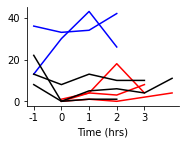

In [10]:
df = {}
# Right Cells
life_iter = 1
control_iter = 1
spot_iter = 1
ax = plt.subplot(2,2,1)
for key in DataDict:
    if key.split('_')[0] == 'LifetimeTricaine':
        
        plot_val = DataDict[key][:,2] 
        df['Lifetime'+str(life_iter)] = [0] + list(plot_val)
        plt.plot(1+np.array(range(DataDict[key].shape[0])),plot_val,'r')
        life_iter = life_iter+1
        
    elif key.split('_')[0] == 'ControlFish':
        plot_val = DataDict[key][:,2] 
        df['Control'+str(control_iter)] = list(plot_val)
        plt.plot(plot_val,'b')
        control_iter = control_iter + 1
    else: 
        plot_val = DataDict[key][:,2] 
        plt.plot(plot_val,'k')
        df['Spot'+str(spot_iter)] = list(plot_val)
        spot_iter = spot_iter + 1
plt.xticks([])
for bounds in ['right','top']:
    right_side = ax.spines[bounds]
    right_side.set_visible(False)
    right_side = ax.spines[bounds]
    right_side.set_visible(False)

plt.xticks([0,1,2,3,4])
ax.set(xticklabels = [-1,0,1,2,3])
plt.xlabel('Time (hrs)')
#plt.savefig('Figures/Figure4/CellTypesFitted.pdf',bbox_inches='tight') 
df

## Other Plots

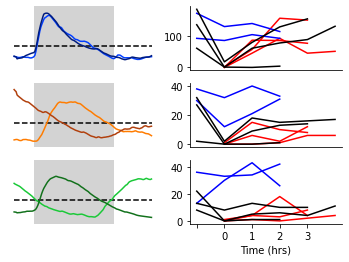

In [8]:

# On Cells

i = 0
ax = plt.subplot(3,2,1)
ax.add_patch(patches.Rectangle((20, -2), 80, 50000, edgecolor='lightgrey', facecolor='lightgrey', fill=True))
plt.plot([0, 140], [0, 0], linestyle='--', color='black')
pl.plot(left_cells_response_left_cluster_means[i],color=sns.color_palette("bright")[i])
pl.plot(right_cells_response_right_cluster_means[i],color=sns.color_palette("dark")[i])
pl.ylim([-1.5,2.5])
plt.yticks([])
plt.xticks([])
for bounds in ['right','top','left','bottom']:
    right_side = ax.spines[bounds]
    right_side.set_visible(False)
    right_side = ax.spines[bounds]
    right_side.set_visible(False)
ax = plt.subplot(3,2,2)
for key in DataDict:
    if key.split('_')[0] == 'LifetimeTricaine':
        plot_val = DataDict[key][:,0] + DataDict[key][:,4] + DataDict[key][:,5]
        plt.plot(1+np.array(range(DataDict[key].shape[0])),plot_val,'r')
        
    elif key.split('_')[0] == 'ControlFish':
        plot_val = DataDict[key][:,0] + DataDict[key][:,4] + DataDict[key][:,5]
        plt.plot(plot_val,'b')
    else: 
        plot_val = DataDict[key][:,0] + DataDict[key][:,4] + DataDict[key][:,5]
        plt.plot(plot_val,'k')
plt.xticks([])
for bounds in ['right','top']:
    right_side = ax.spines[bounds]
    right_side.set_visible(False)
    right_side = ax.spines[bounds]
    right_side.set_visible(False)
if i > 5:
    plt.xticks([0,1,2,3,4])
    ax.set(xticklabels = [-1,0,1,2,3])
    plt.xlabel('Time (hrs)')


# Left Cells
i = 1
ax = plt.subplot(3,2,3)
ax.add_patch(patches.Rectangle((20, -2), 80, 50000, edgecolor='lightgrey', facecolor='lightgrey', fill=True))
plt.plot([0, 140], [0, 0], linestyle='--', color='black')
pl.plot(left_cells_response_left_cluster_means[i],color=sns.color_palette("bright")[i])
pl.plot(right_cells_response_right_cluster_means[i],color=sns.color_palette("dark")[i])
pl.ylim([-1.5,2.5])
plt.yticks([])
plt.xticks([])
for bounds in ['right','top','left','bottom']:
    right_side = ax.spines[bounds]
    right_side.set_visible(False)
    right_side = ax.spines[bounds]
    right_side.set_visible(False)
ax = plt.subplot(3,2,4)
for key in DataDict:
    if key.split('_')[0] == 'LifetimeTricaine':
        plot_val = DataDict[key][:,6]
        plt.plot(1+np.array(range(DataDict[key].shape[0])),plot_val,'r')
        
    elif key.split('_')[0] == 'ControlFish':
        plot_val =DataDict[key][:,6]
        plt.plot(plot_val,'b')
    else: 
        plot_val = DataDict[key][:,6]        
        plt.plot(plot_val,'k')
plt.xticks([])
for bounds in ['right','top']:
    right_side = ax.spines[bounds]
    right_side.set_visible(False)
    right_side = ax.spines[bounds]
    right_side.set_visible(False)
if i > 5:
    plt.xticks([0,1,2,3,4])
    ax.set(xticklabels = [-1,0,1,2,3])
    plt.xlabel('Time (hrs)')

# Right cells
i = 2
ax = plt.subplot(3,2,5)
ax.add_patch(patches.Rectangle((20, -2), 80, 50000, edgecolor='lightgrey', facecolor='lightgrey', fill=True))
plt.plot([0, 140], [0, 0], linestyle='--', color='black')
pl.plot(left_cells_response_left_cluster_means[i],color=sns.color_palette("bright")[i])
pl.plot(right_cells_response_right_cluster_means[i],color=sns.color_palette("dark")[i])
pl.ylim([-1.5,2.5])
plt.yticks([])
plt.xticks([])
for bounds in ['right','top','left','bottom']:
    right_side = ax.spines[bounds]
    right_side.set_visible(False)
    right_side = ax.spines[bounds]
    right_side.set_visible(False)
ax = plt.subplot(3,2,6)
#plt.plot([0.5,0.5],[-10,120],linestyle = '--',color = 'g')
#plt.plot([1.5,1.5],[-10,120],linestyle = '--',color = 'g')
for key in DataDict:
    if key.split('_')[0] == 'LifetimeTricaine':
        plot_val = DataDict[key][:,2]
        plt.plot(1+np.array(range(DataDict[key].shape[0])),plot_val,'r')
        
    elif key.split('_')[0] == 'ControlFish':
        plot_val = DataDict[key][:,2] 
        plt.plot(plot_val,'b')
    else: 
        plot_val = DataDict[key][:,2] 
        plt.plot(plot_val,'k')
plt.xticks([])
for bounds in ['right','top']:
    right_side = ax.spines[bounds]
    right_side.set_visible(False)
    right_side = ax.spines[bounds]
    right_side.set_visible(False)
if i > 0:
    plt.xticks([0,1,2,3,4])
    ax.set(xticklabels = ['',0,1,2,3])
    plt.xlabel('Time (hrs)')
#plt.savefig('CellTypesFitted.pdf',bbox_inches='tight') 

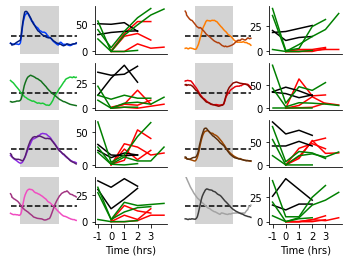

In [17]:
for i in range(8):
    ax = plt.subplot(4,4,2*i+1)
    ax.add_patch(patches.Rectangle((20, -2), 80, 50000, edgecolor='lightgrey', facecolor='lightgrey', fill=True))
    plt.plot([0, 140], [0, 0], linestyle='--', color='black')
    pl.plot(left_cells_response_left_cluster_means[i],color=sns.color_palette("bright")[i])
    pl.plot(right_cells_response_right_cluster_means[i],color=sns.color_palette("dark")[i])
    pl.ylim([-1.5,2.5])
    plt.yticks([])
    plt.xticks([])
    for bounds in ['right','top','left','bottom']:
        right_side = ax.spines[bounds]
        right_side.set_visible(False)
        right_side = ax.spines[bounds]
        right_side.set_visible(False)
    ax = plt.subplot(4,4,2*i+2)
    for key in DataDict:
        if key.split('_')[0] == 'LifetimeTricaine':
            plt.plot(1+np.array(range(DataDict[key].shape[0])),DataDict[key][:,i],'r')
            
        elif key.split('_')[0] == 'ControlFish':
            plt.plot(DataDict[key][:,i],'k')
        else: 
            plt.plot(DataDict[key][:,i],'g')
    plt.xticks([])
    for bounds in ['right','top']:
        right_side = ax.spines[bounds]
        right_side.set_visible(False)
        right_side = ax.spines[bounds]
        right_side.set_visible(False)
    if i > 5:
        plt.xticks([0,1,2,3,4])
        ax.set(xticklabels = [-1,0,1,2,3])
        plt.xlabel('Time (hrs)')
#plt.savefig('CellTypesFitted_all.pdf',bbox_inches='tight') 

# Example Traces

In [2]:
def LoadData(NewPath):
 
    fish_path = NewPath

    file = str(fish_path)+'/z_plane0000_trial000_trials_stimulus_aligned_C.pickle'
    trials_stimulus_aligned_C = pickle.load(open(file, 'rb'))



    z_plane = 0 # 7         # Set this according to file name?
    trial = 0               # Set this according to file name?
    unit_contours = pickle.load(open(fish_path / f'z_plane{z_plane:04d}_trial{trial:03d}_contours.pickle', 'rb'))



    #                                               Baseline correction
    # ======================================================================================================================
    # for each cell, measure the baseline C in a 10 sec window right before stimulus onset (20 - 40, i.e. 10 to 20 sec sampled at 2 Hz)
    # for each cell, subtract this baseline measurement from all its C values
    # function used is A -= B, i.e. A = A - B, so the 'trials_stimulus_aligned_C' gets over-written!

    for stim_key in trials_stimulus_aligned_C.keys():       # 0 or 1 -> loop through stimulus types (left or right)
        for trial_n in range(np.shape(trials_stimulus_aligned_C[stim_key])[0]): # loop through the trials (e.g. 28 trials to left)
            for unit_i in range(np.shape(trials_stimulus_aligned_C[stim_key])[1]): # loop through the cells
                trials_stimulus_aligned_C[stim_key][trial_n][unit_i] -= \
                    np.nanmean(trials_stimulus_aligned_C[stim_key][trial_n][unit_i][int(10/0.5):int(20/0.5)])

    #                                   Determine the 'responsiveness' of cells
    # ======================================================================================================================

    # split up 'trials_stimulus_aligned_C' into left and right trials and make into numpy arrays for easier indexing
    left_trials = np.array(trials_stimulus_aligned_C[0])
    right_trials = np.array(trials_stimulus_aligned_C[1])
    cell_infos = []

    for unit_i in range(np.shape(unit_contours)[0]):
        x, y = np.nanmean(unit_contours[unit_i], axis=0) # get the centroid of the contours

        # for each cell, generate average response to left and right motion across all respective trials, then search for the absolute of the max activity
        # -> readout for how much a cell responds to respective motion

        responsiveness_left = np.abs(np.nanmean(left_trials[:,unit_i,20:160], axis=0)).max() # is the cell doing anything after baseline subtraction??
        responsiveness_right = np.abs(np.nanmean(right_trials[:,unit_i,20:160], axis=0)).max()

        # for each cell, save its centroid's x and y position and its max responsiveness to left and right motion
        cell_infos.append([x, y, responsiveness_left, responsiveness_right])

    cell_infos = np.array(cell_infos)

    temporal_average = imread(os.path.join(fish_path,
                                       "z_plane0000_trial000_imaging_roi00_green_channel_motion_corrected.tif".format(
                                           z_plane)))
    # conversion from 16 bit to 8 bit:
    temporal_average = np.array(temporal_average * (np.power(2,8) / np.power(2,16)))
    # -> use full range: subtract min, divide max, multiply by 256, convert in float first
    # could do better in Fiji and load into Pycharm
    temporal_average[temporal_average < 0] = 0
    temporal_average[temporal_average > 255] = 255
    temporal_average = np.array(temporal_average, dtype=np.uint8)
    temporal_average = temporal_average.mean(0)

    return left_trials, right_trials

In [3]:
BasicPath = "/Volumes/BigFishThry/GoodGregor2P/SpotTricaine/"

Dates = [i for i in os.listdir(BasicPath)]
date = 'Jan19_LargeLong'
AltPath = BasicPath + date + "/"
files = [i for i in os.listdir(AltPath) if "2022" in i]
files.sort()

print(AltPath)
len(files)
for file in files:
    left_trials,right_trials = LoadData(Path(AltPath+file+"/rawdata"))
    if file == files[0]:
        LeftTrials_Meta = left_trials[:24,:,:]
        RightTrials_Meta = right_trials[:24,:,:]
    else:
        LeftTrials_Meta = np.append(LeftTrials_Meta,left_trials[:24,:,:],axis = 0)
        RightTrials_Meta = np.append(RightTrials_Meta,right_trials[:24,:,:],axis = 0)

/Volumes/BigFishThry/GoodGregor2P/SpotTricaine/Jan19_LargeLong/


/Users/danielbarabasi/opt/anaconda3/envs/OMR/lib/python3.9/site-packages/numpy/core/fromnumeric.py:2007: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


### Spot Motion Cells

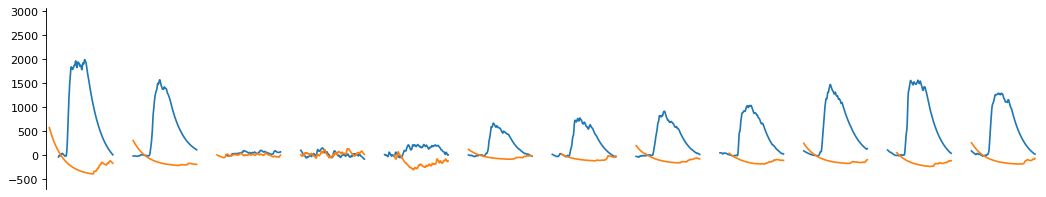

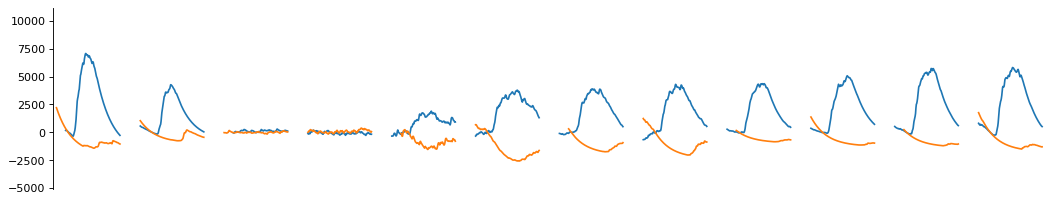

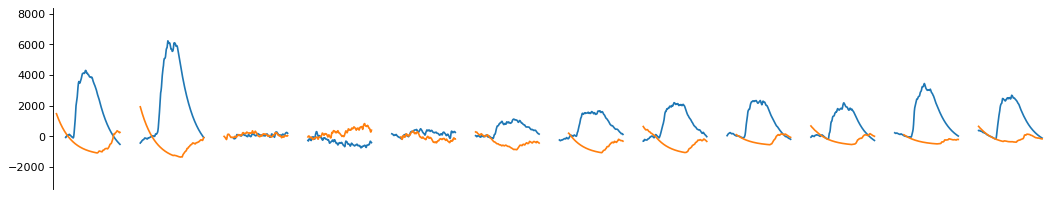

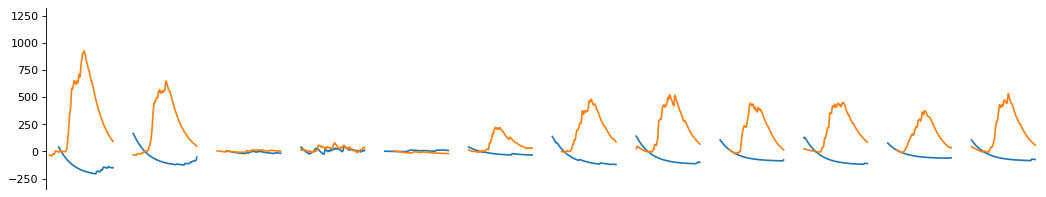

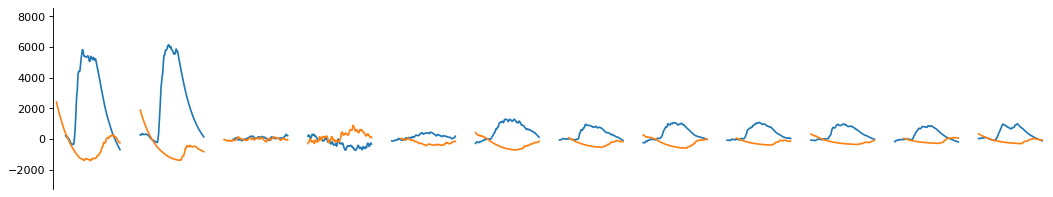

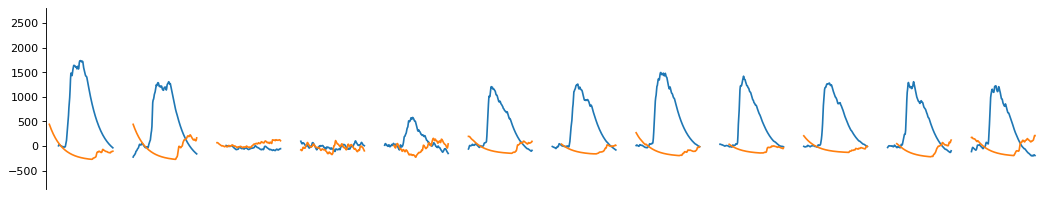

In [70]:
for cell in [252,246,567,222,247,251]: # Motion Sensitive
    plt.figure(figsize=(16, 3), dpi=80)
    ymax = max([np.nanmax(LeftTrials_Meta[:,cell,:]),np.nanmax(RightTrials_Meta[:,cell,:])])
    ymin = min([np.nanmin(LeftTrials_Meta[:,cell,:]),np.nanmin(RightTrials_Meta[:,cell,:])])
    for experiments in range(int(RightTrials_Meta.shape[0]/24)):
        ax = plt.subplot(1,int(RightTrials_Meta.shape[0]/24)*2,2*experiments+1)
        plt.plot(np.mean(LeftTrials_Meta[experiments*24:experiments*24+10,cell,:],axis=0))
        plt.plot(np.mean(RightTrials_Meta[experiments*24:experiments*24+10,cell,:],axis=0))

        plt.ylim([ymin,ymax])
        plt.xticks([])
        if experiments == 0:
            for bounds in ['right','top','bottom']:
                right_side = ax.spines[bounds]
                right_side.set_visible(False)
                right_side = ax.spines[bounds]
                right_side.set_visible(False)
        else:
            plt.yticks([])
            for bounds in ['right','top','bottom','left']:
                right_side = ax.spines[bounds]
                right_side.set_visible(False)
                right_side = ax.spines[bounds]
                right_side.set_visible(False)



        ax = plt.subplot(1,int(RightTrials_Meta.shape[0]/24)*2,2*experiments+2)
        plt.plot(np.mean(LeftTrials_Meta[(experiments+1)*24-10:(experiments+1)*24,cell,:],axis=0))
        plt.plot(np.mean(RightTrials_Meta[(experiments+1)*24-10:(experiments+1)*24,cell,:],axis=0))
        plt.ylim([ymin,ymax])
        plt.xticks([])
        plt.yticks([])
        for bounds in ['left','bottom','right','top']:
            right_side = ax.spines[bounds]
            right_side.set_visible(False)
            right_side = ax.spines[bounds]
            right_side.set_visible(False)

## Lifetime Cells

In [4]:
BasicPath = "/Volumes/BigFishThry/GoodGregor2P/LifetimeTricaine/"

Dates = [i for i in os.listdir(BasicPath)]
date = 'Feb17_LargeLong'
AltPath = BasicPath + date + "/"
files = [i for i in os.listdir(AltPath) if "2022" in i]
files.sort()

print(AltPath)
len(files)
for file in files:
    left_trials,right_trials = LoadData(Path(AltPath+file+"/rawdata"))
    if file == files[0]:
        Lifetime_LeftTrials_Meta = left_trials[:24,:,:]
        Lifetime_RightTrials_Meta = right_trials[:24,:,:]
    else:
        Lifetime_LeftTrials_Meta = np.append(Lifetime_LeftTrials_Meta,left_trials[:24,:,:],axis = 0)
        Lifetime_RightTrials_Meta = np.append(Lifetime_RightTrials_Meta,right_trials[:24,:,:],axis = 0)

/Volumes/BigFishThry/GoodGregor2P/LifetimeTricaine/Feb17_LargeLong/


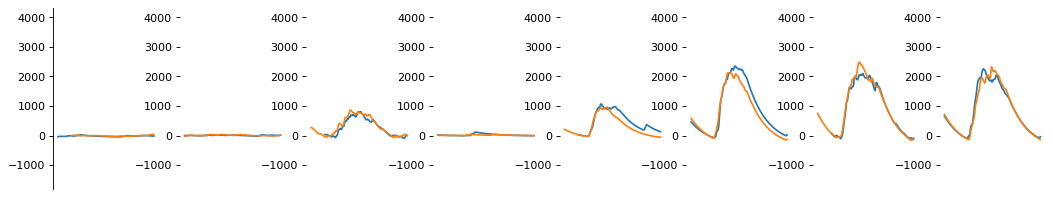

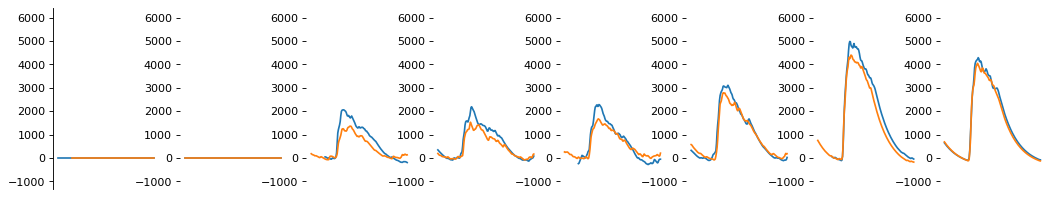

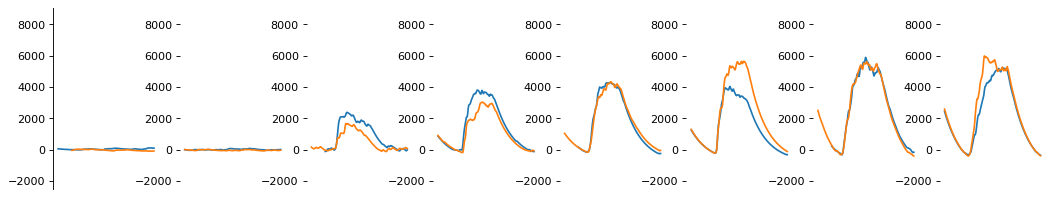

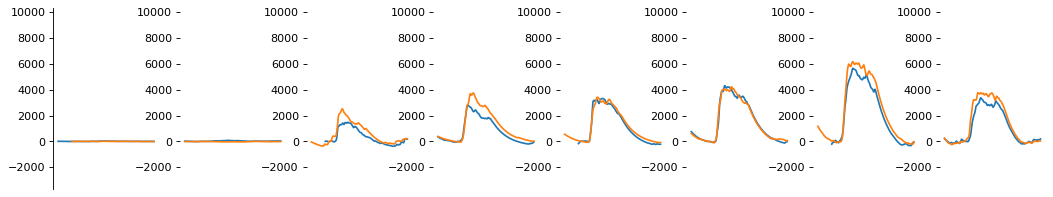

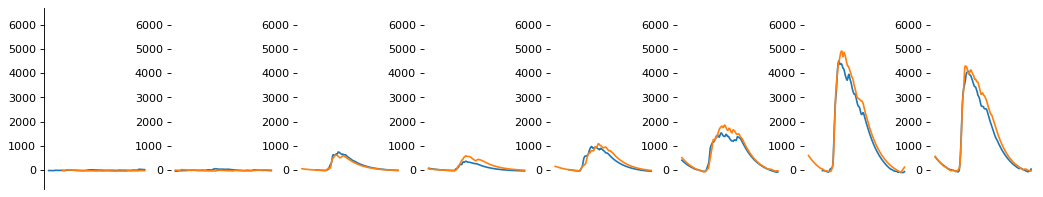

In [20]:
for on_cell in [78,498,486,627,43]: # On Cells
    plt.figure(figsize=(16, 3), dpi=80)
    ymax = max([np.nanmax(Lifetime_LeftTrials_Meta[:,on_cell,:]),np.nanmax(Lifetime_RightTrials_Meta[:,on_cell,:])])
    ymin = min([np.nanmin(Lifetime_LeftTrials_Meta[:,on_cell,:]),np.nanmin(Lifetime_RightTrials_Meta[:,on_cell,:])])
    for experiments in range(int(Lifetime_RightTrials_Meta.shape[0]/24)):
        ax = plt.subplot(1,int(Lifetime_RightTrials_Meta.shape[0]/24)*2,2*experiments+1)
        plt.plot(np.mean(Lifetime_LeftTrials_Meta[experiments*24:experiments*24+10,on_cell,:],axis=0))
        plt.plot(np.mean(Lifetime_RightTrials_Meta[experiments*24:experiments*24+10,on_cell,:],axis=0))

        plt.ylim([ymin,ymax])
        plt.xticks([])
        if experiments == 0:
            for bounds in ['right','top','bottom']:
                right_side = ax.spines[bounds]
                right_side.set_visible(False)
                right_side = ax.spines[bounds]
                right_side.set_visible(False)
        else:
            #plt.yticks([])
            for bounds in ['right','top','bottom','left']:
                right_side = ax.spines[bounds]
                right_side.set_visible(False)
                right_side = ax.spines[bounds]
                right_side.set_visible(False)



        ax = plt.subplot(1,int(Lifetime_RightTrials_Meta.shape[0]/24)*2,2*experiments+2)
        plt.plot(np.mean(Lifetime_LeftTrials_Meta[(experiments+1)*24-10:(experiments+1)*24,on_cell,:],axis=0))
        plt.plot(np.mean(Lifetime_RightTrials_Meta[(experiments+1)*24-10:(experiments+1)*24,on_cell,:],axis=0))
        plt.ylim([ymin,ymax])
        plt.xticks([])
        #plt.yticks([])
        for bounds in ['left','bottom','right','top']:
            right_side = ax.spines[bounds]
            right_side.set_visible(False)
            right_side = ax.spines[bounds]
            right_side.set_visible(False)

### Lifetime Motion Cells

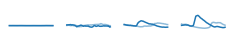

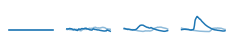

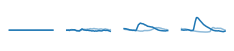

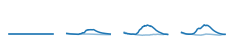

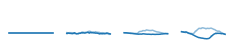

In [71]:
for on_cell in [254,226,494,157,143]: # Motion Cells
    plt.figure()
    c = sns.color_palette("viridis",n_colors = 3*(len(files)))

    ymax = max([np.nanmax(Lifetime_LeftTrials_Meta[:,on_cell,:]),np.nanmax(Lifetime_RightTrials_Meta[:,on_cell,:])])
    #ymax = 2500
    ymin = min([np.nanmin(Lifetime_LeftTrials_Meta[:,on_cell,:]),np.nanmin(Lifetime_RightTrials_Meta[:,on_cell,:])])
    num_experiments = int(Lifetime_RightTrials_Meta.shape[0]/24)
    for experiments in range(num_experiments):
        ax = plt.subplot(numrows,int(RightTrials_Meta.shape[0]/24),int(RightTrials_Meta.shape[0]/24)+experiments+2)
        plt.plot(np.nanmean(Lifetime_LeftTrials_Meta[experiments*24:experiments*24+24,on_cell,:],axis=0),color = sns.color_palette()[0],alpha = 0.5)
        plt.plot(np.nanmean(Lifetime_RightTrials_Meta[experiments*24:experiments*24+24,on_cell,:],axis=0),color = sns.color_palette()[0])

        plt.ylim([ymin,ymax])
        plt.xticks([])
        if experiments == -1:
            for bounds in ['right','top','bottom']:
                right_side = ax.spines[bounds]
                right_side.set_visible(False)
                right_side = ax.spines[bounds]
                right_side.set_visible(False)
        else:
            plt.yticks([])
            for bounds in ['right','top','bottom','left']:
                right_side = ax.spines[bounds]
                right_side.set_visible(False)
                right_side = ax.spines[bounds]
                right_side.set_visible(False)

## Combined Lifetime and Spot

## Locations

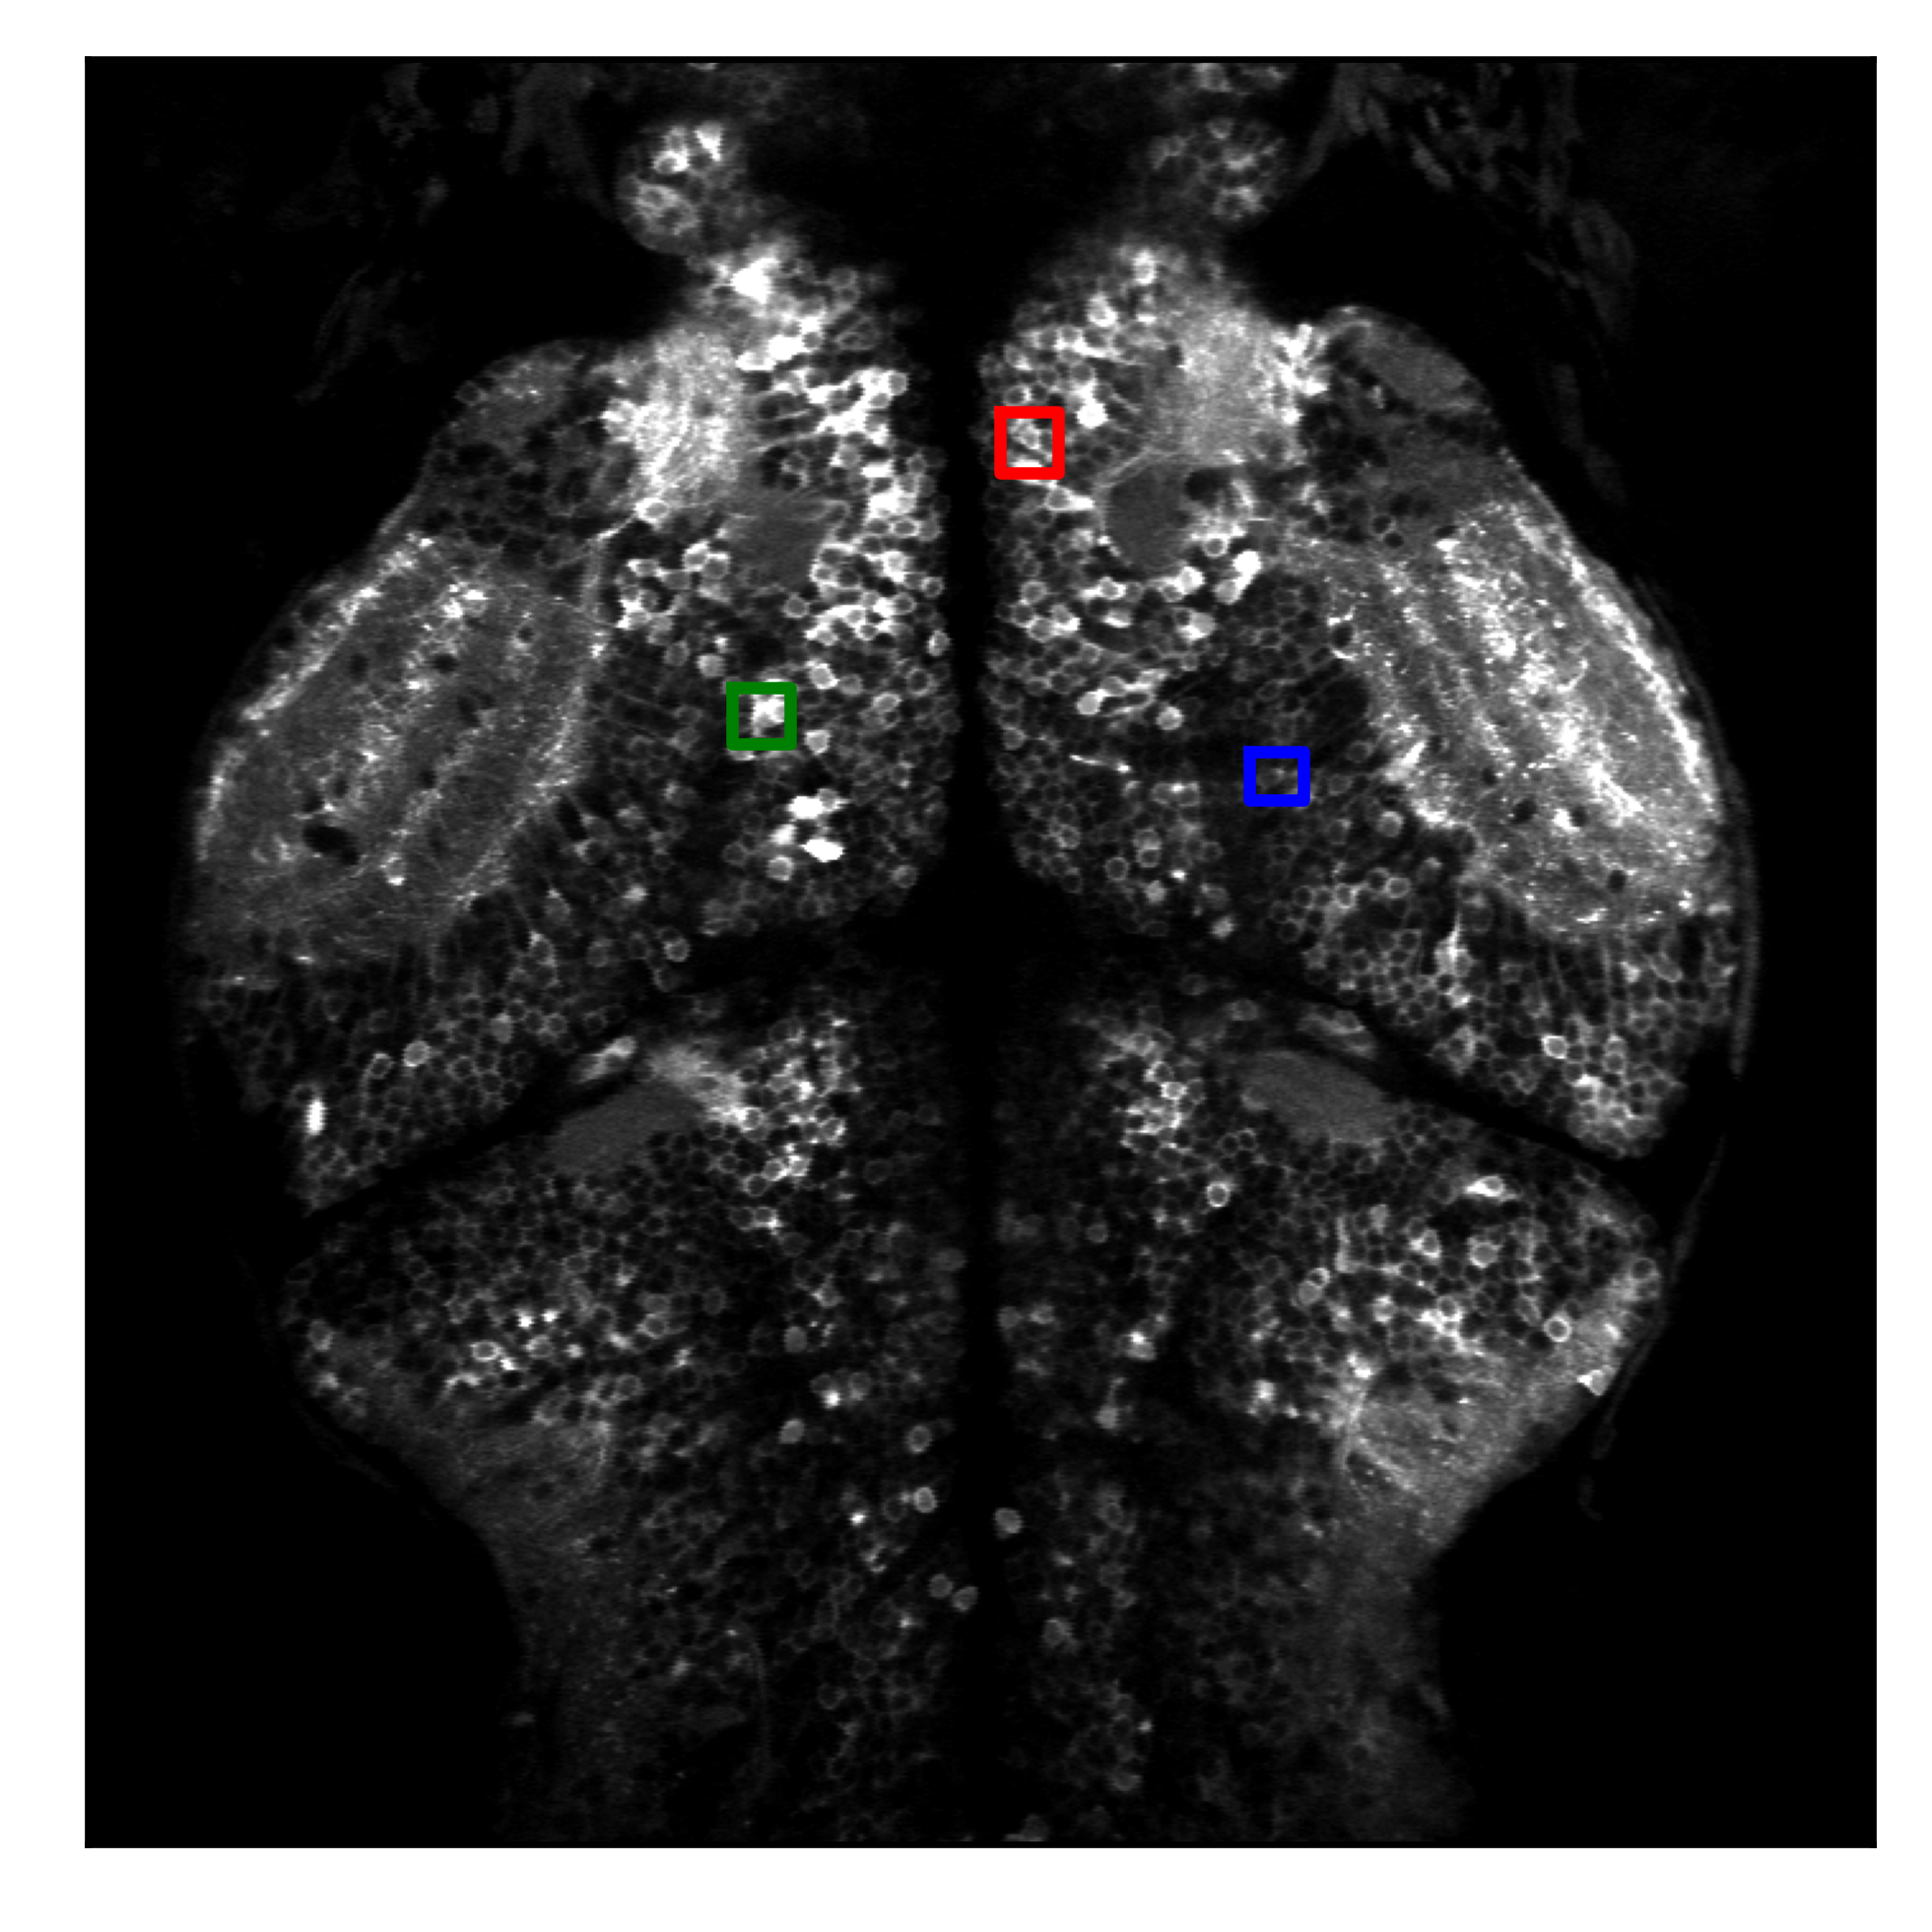

In [3]:
concatenated_stacks_path = Path('/Volumes/BigFishThry/GlobalAndRegionalTraces/Lifetime/')
# ======================================================================================================================
#                                    Plot averaged image overlaid by all contours
# ======================================================================================================================
# TODO: load a nice Fiji-processed image (perform brightness/contrast adjustments in Fiji)
Fiji_image = plt.imread(str(concatenated_stacks_path)+"/Feb17/AVG_1hr.tif")
unit_contours = pickle.load(open('/Volumes/BigFishThry/GoodGregor2P/LifetimeTricaine/Feb17_LargeLong/2022-02-17_13-42-44/rawdata/z_plane0000_trial000_contours.pickle', 'rb'))


contours = unit_contours
plt.figure(dpi=600)
axis = plt.imshow(Fiji_image, cmap='gray')

count = 78
delta = 7
minx = math.floor(132+np.nanmin(contours[count][:, 0])-7)
miny = math.floor(10+np.nanmin(contours[count][:, 1])-7)
maxx = math.ceil(132+np.nanmax(contours[count][:, 0])+7)
maxy = math.ceil(10+np.nanmax(contours[count][:, 1])+7)

plt.plot([minx,maxx,maxx,minx,minx],[miny,miny,maxy,maxy,miny], color = 'r')
plt.xticks([])
plt.yticks([])


count = 143
delta = 7
minx = math.floor(132+np.nanmin(contours[count][:, 0])-7)
miny = math.floor(10+np.nanmin(contours[count][:, 1])-7)
maxx = math.ceil(132+np.nanmax(contours[count][:, 0])+7)
maxy = math.ceil(10+np.nanmax(contours[count][:, 1])+7)

plt.plot([minx,maxx,maxx,minx,minx],[miny,miny,maxy,maxy,miny], color = 'g')
plt.xticks([])
plt.yticks([])

count = 157
delta = 7
minx = math.floor(132+np.nanmin(contours[count][:, 0])-7)
miny = math.floor(10+np.nanmin(contours[count][:, 1])-7)
maxx = math.ceil(132+np.nanmax(contours[count][:, 0])+7)
maxy = math.ceil(10+np.nanmax(contours[count][:, 1])+7)

plt.plot([minx,maxx,maxx,minx,minx],[miny,miny,maxy,maxy,miny], color = 'b')
plt.xticks([])
plt.yticks([])

plt.savefig('Figures/Figure4/Cells.pdf',bbox_inches='tight') 
plt.show()
#plt.savefig('QuickTest.pdf')

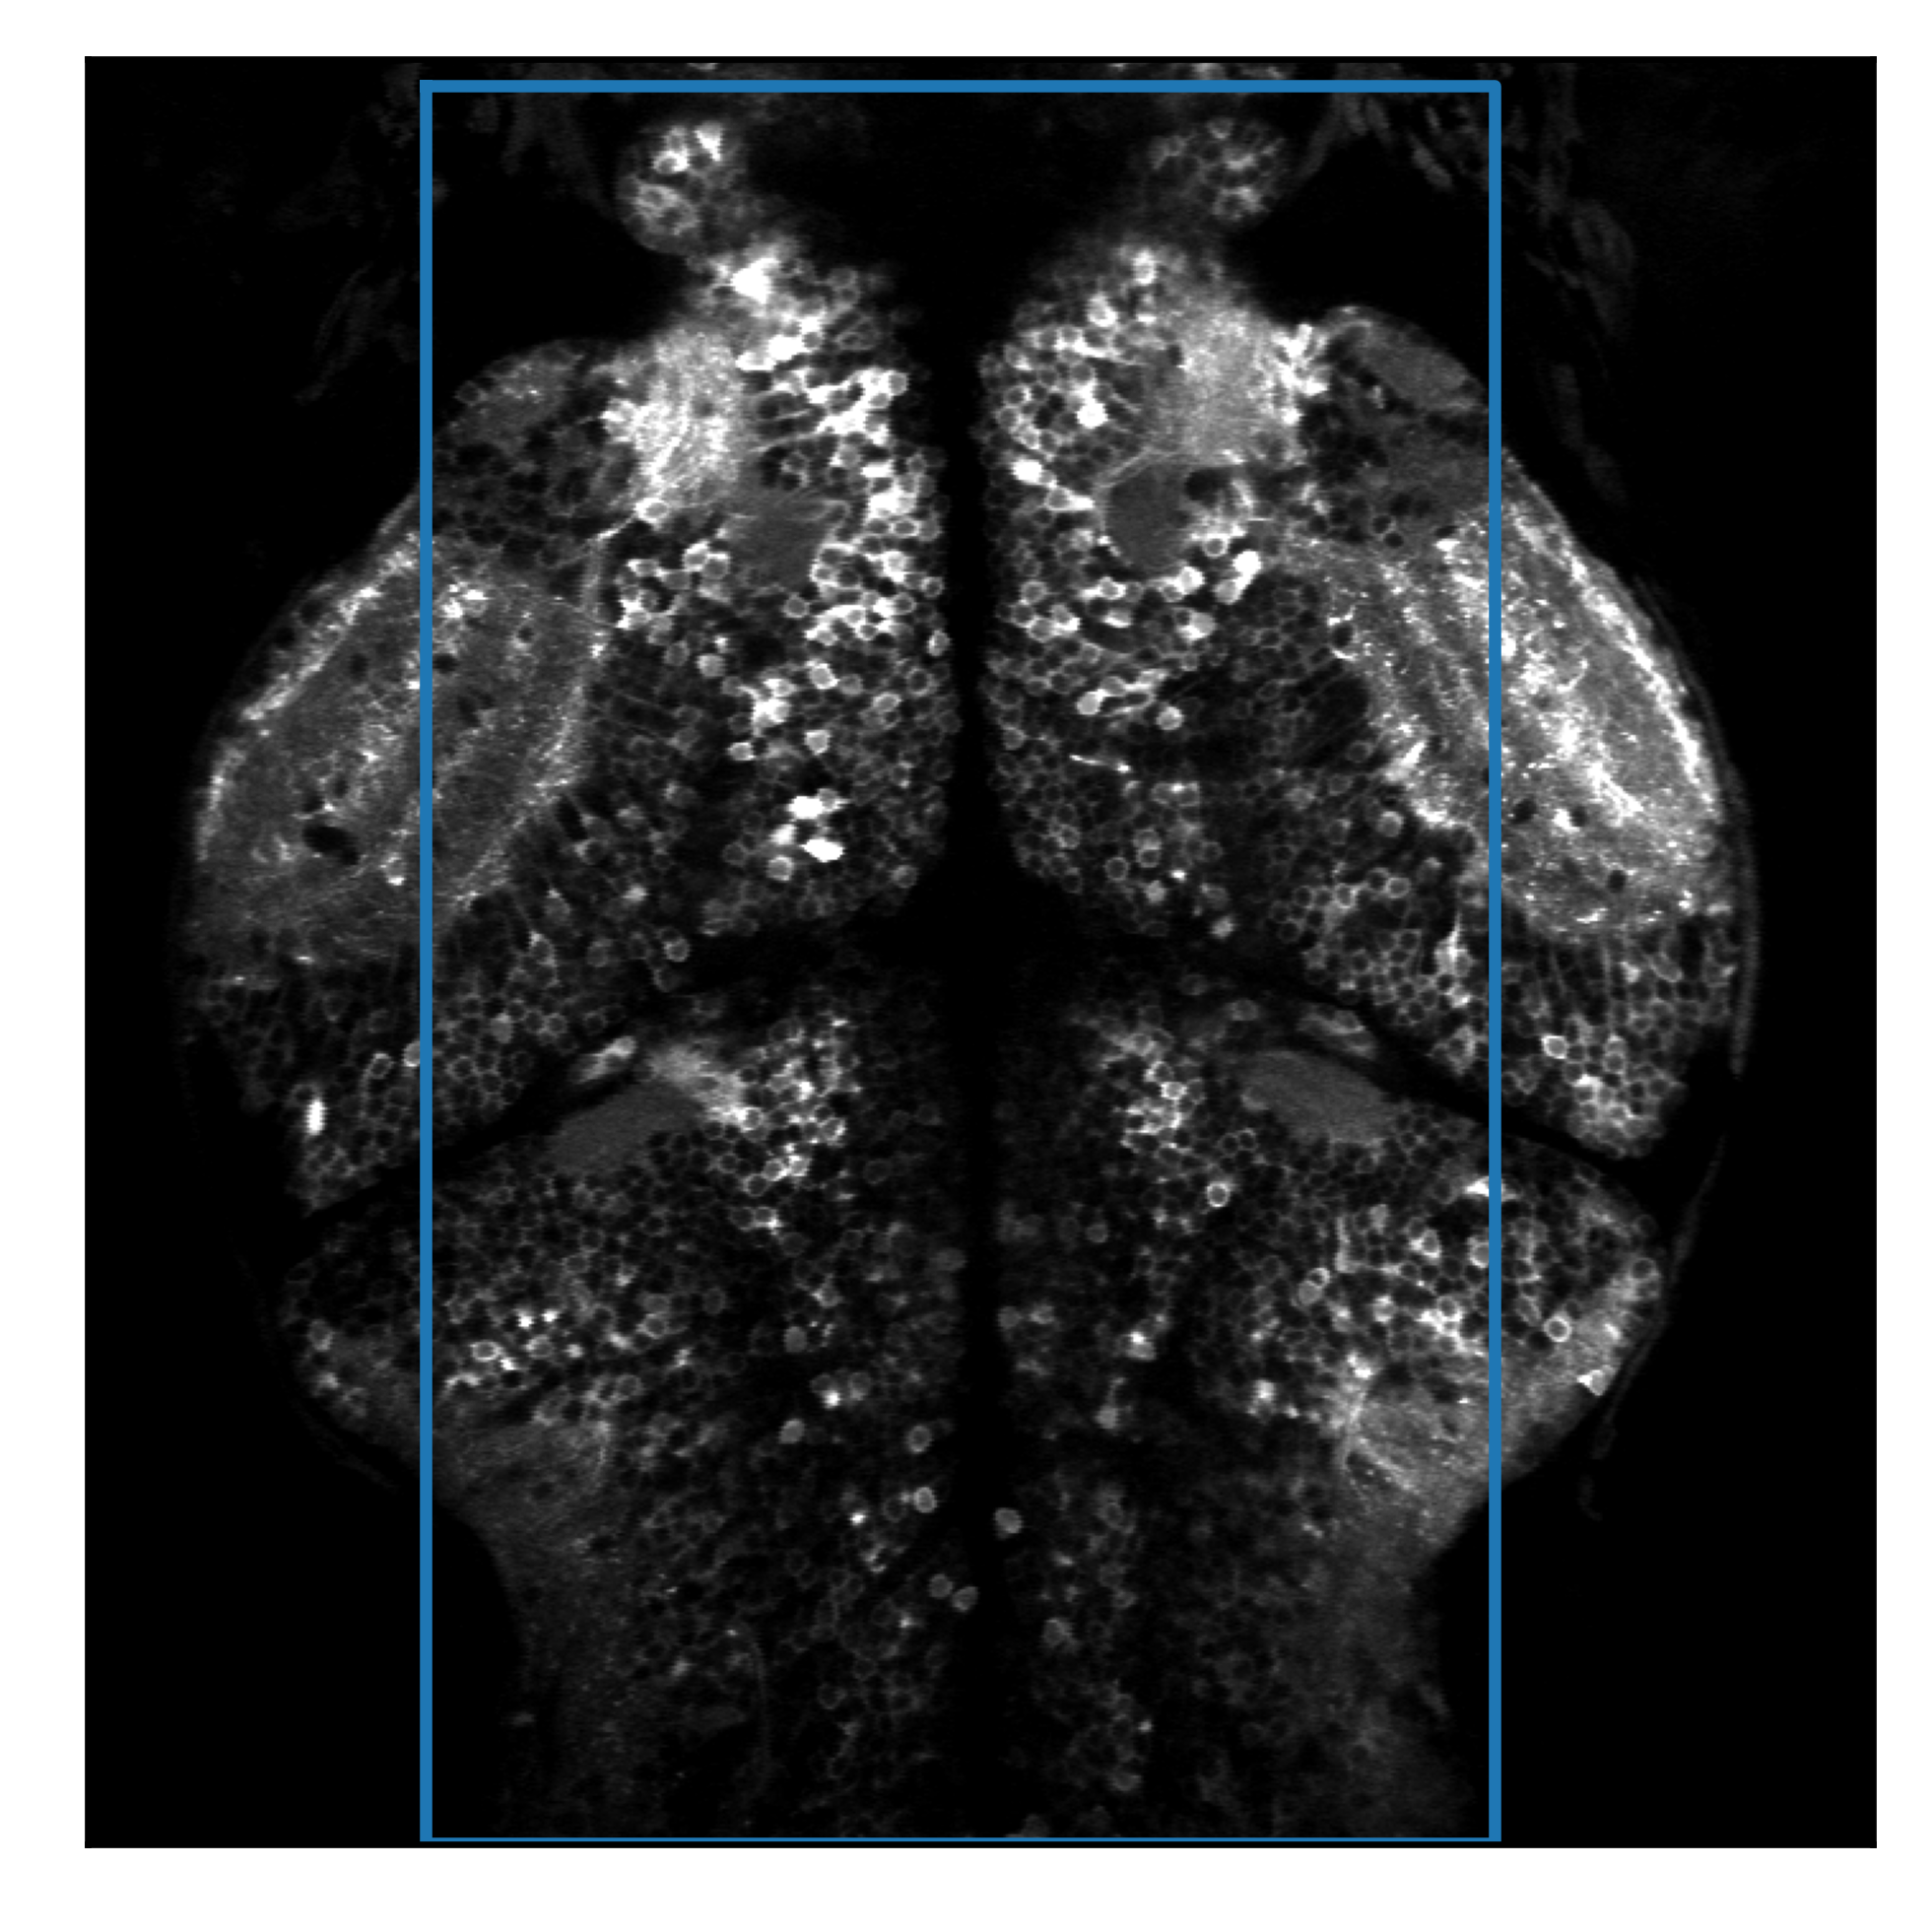

In [92]:
concatenated_stacks_path = Path('/Volumes/BigFishThry/GlobalAndRegionalTraces/Lifetime/')
# ======================================================================================================================
#                                    Plot averaged image overlaid by all contours
# ======================================================================================================================
# TODO: load a nice Fiji-processed image (perform brightness/contrast adjustments in Fiji)
Fiji_image = plt.imread(str(concatenated_stacks_path)+"/Feb17/AVG_1hr.tif")



plt.figure(dpi=600)
axis = plt.imshow(Fiji_image, cmap='gray')
plt.plot([132,132+419,132+419,132,132],[10,10,10+689,10+689,10])
plt.xticks([])
plt.yticks([])
#plt.savefig('QuickTest.pdf',bbox_inches='tight') 
plt.savefig('Figures/Figure4/Zoom.pdf',bbox_inches='tight') 

plt.show()

### On Cells

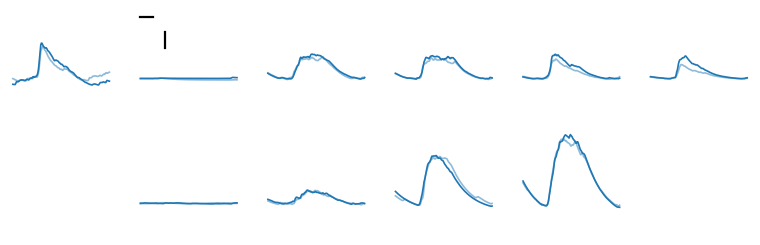

In [5]:
numrows = 5

date = 'Jan19_LargeLong'
plt.figure(figsize=(12, 10), dpi=80)
ymin = -1100
ymax = 2300

concatenated_stacks_path = Path('/Volumes/BigFishThry/GoodGregor2P/SpotTricaine/' + date)

AltPath = str(concatenated_stacks_path) + "/"
files = [i for i in os.listdir(AltPath) if "2022" in i]
files.sort()

contours = pd.read_pickle(str(concatenated_stacks_path)+"/" + files[0] + "/rawdata/z_plane0000_trial000_contours.pickle")

ct = '1'

count = 129

c = sns.color_palette("viridis",n_colors = 3*(len(files)))

on_cell = count 
#ymax = max([np.nanmax(LeftTrials_Meta[:,on_cell,:]),np.nanmax(RightTrials_Meta[:,on_cell,:])])
#ymax = 2500
#ymin = min([np.nanmin(LeftTrials_Meta[:,on_cell,:]),np.nanmin(RightTrials_Meta[:,on_cell,:])])
num_experiments = int(RightTrials_Meta.shape[0]/24)
for experiments in range(num_experiments):
    ax = plt.subplot(numrows,num_experiments,experiments+1)
    plt.plot(np.nanmean(LeftTrials_Meta[experiments*24:experiments*24+24,on_cell,:],axis=0),color = sns.color_palette()[0],alpha = 0.5)
    plt.plot(np.nanmean(RightTrials_Meta[experiments*24:experiments*24+24,on_cell,:],axis=0),color = sns.color_palette()[0])

    plt.ylim([ymin,ymax])
    plt.xticks([])
    if experiments == 1:
         plt.plot([0,20],[2000,2000],color = 'k',linewidth = 2)
         plt.plot([40,40],[1000,1500],color = 'k',linewidth = 2)
    if experiments == -1:
        for bounds in ['right','top','bottom']:
            right_side = ax.spines[bounds]
            right_side.set_visible(False)
            right_side = ax.spines[bounds]
            right_side.set_visible(False)
    else:
        plt.yticks([])
        for bounds in ['right','top','bottom','left']:
            right_side = ax.spines[bounds]
            right_side.set_visible(False)
            right_side = ax.spines[bounds]
            right_side.set_visible(False)



count = 78

c = sns.color_palette("viridis",n_colors = 3*(len(files)))

on_cell = count 
##ymax = max([np.nanmax(Lifetime_LeftTrials_Meta[:,on_cell,:]),np.nanmax(Lifetime_RightTrials_Meta[:,on_cell,:])])
#ymax = 2500
#ymin = min([np.nanmin(Lifetime_LeftTrials_Meta[:,on_cell,:]),np.nanmin(Lifetime_RightTrials_Meta[:,on_cell,:])])
num_experiments = int(Lifetime_RightTrials_Meta.shape[0]/24)
for experiments in range(num_experiments):
    ax = plt.subplot(numrows,int(RightTrials_Meta.shape[0]/24),int(RightTrials_Meta.shape[0]/24)+experiments+2)
    plt.plot(np.nanmean(Lifetime_LeftTrials_Meta[experiments*24:experiments*24+24,on_cell,:],axis=0),color = sns.color_palette()[0],alpha = 0.5)
    plt.plot(np.nanmean(Lifetime_RightTrials_Meta[experiments*24:experiments*24+24,on_cell,:],axis=0),color = sns.color_palette()[0])

    plt.ylim([ymin,ymax])
    plt.xticks([])
    if experiments == -1:
        for bounds in ['right','top','bottom']:
            right_side = ax.spines[bounds]
            right_side.set_visible(False)
            right_side = ax.spines[bounds]
            right_side.set_visible(False)
    else:
        plt.yticks([])
        for bounds in ['right','top','bottom','left']:
            right_side = ax.spines[bounds]
            right_side.set_visible(False)
            right_side = ax.spines[bounds]
            right_side.set_visible(False)
pl.savefig('Figures/Figure4/OnCellTraces.pdf',bbox_inches='tight') 

### Motion Cells

## Left

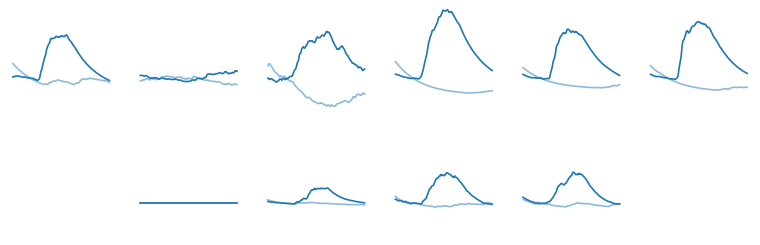

In [6]:
numrows = 5

date = 'Jan19_LargeLong'
plt.figure(figsize=(12, 10), dpi=80)
#ymin = -1500
#ymax = 2500

concatenated_stacks_path = Path('/Volumes/BigFishThry/GoodGregor2P/SpotTricaine/' + date)

AltPath = str(concatenated_stacks_path) + "/"
files = [i for i in os.listdir(AltPath) if "2022" in i]
files.sort()

contours = pd.read_pickle(str(concatenated_stacks_path)+"/" + files[0] + "/rawdata/z_plane0000_trial000_contours.pickle")

ct = '1'

count = 544

c = sns.color_palette("viridis",n_colors = 3*(len(files)))

on_cell = count 
#ymax = max([np.nanmax(LeftTrials_Meta[:,on_cell,:]),np.nanmax(RightTrials_Meta[:,on_cell,:])])
#ymax = 2500
#ymin = min([np.nanmin(LeftTrials_Meta[:,on_cell,:]),np.nanmin(RightTrials_Meta[:,on_cell,:])])
num_experiments = int(RightTrials_Meta.shape[0]/24)
for experiments in range(num_experiments):
    ax = plt.subplot(numrows,num_experiments,experiments+1)
    plt.plot(np.nanmean(LeftTrials_Meta[experiments*24:experiments*24+24,on_cell,:],axis=0),color = sns.color_palette()[0],alpha = 0.5)
    plt.plot(np.nanmean(RightTrials_Meta[experiments*24:experiments*24+24,on_cell,:],axis=0),color = sns.color_palette()[0])

    plt.ylim([ymin,ymax])
    plt.xticks([])
    if experiments == -1:
        for bounds in ['right','top','bottom']:
            right_side = ax.spines[bounds]
            right_side.set_visible(False)
            right_side = ax.spines[bounds]
            right_side.set_visible(False)
    else:
        plt.yticks([])
        for bounds in ['right','top','bottom','left']:
            right_side = ax.spines[bounds]
            right_side.set_visible(False)
            right_side = ax.spines[bounds]
            right_side.set_visible(False)



count = 157

c = sns.color_palette("viridis",n_colors = 3*(len(files)))

on_cell = count 
#ymax = max([np.nanmax(Lifetime_LeftTrials_Meta[:,on_cell,:]),np.nanmax(Lifetime_RightTrials_Meta[:,on_cell,:])])
#ymax = 2500
#ymin = min([np.nanmin(Lifetime_LeftTrials_Meta[:,on_cell,:]),np.nanmin(Lifetime_RightTrials_Meta[:,on_cell,:])])
num_experiments = int(Lifetime_RightTrials_Meta.shape[0]/24)
for experiments in range(num_experiments):
    ax = plt.subplot(numrows,int(RightTrials_Meta.shape[0]/24),int(RightTrials_Meta.shape[0]/24)+experiments+2)
    plt.plot(np.nanmean(Lifetime_LeftTrials_Meta[experiments*24:experiments*24+24,on_cell,:],axis=0),color = sns.color_palette()[0],alpha = 0.5)
    plt.plot(np.nanmean(Lifetime_RightTrials_Meta[experiments*24:experiments*24+24,on_cell,:],axis=0),color = sns.color_palette()[0])

    plt.ylim([ymin,ymax])
    plt.xticks([])
    if experiments == -1:
        for bounds in ['right','top','bottom']:
            right_side = ax.spines[bounds]
            right_side.set_visible(False)
            right_side = ax.spines[bounds]
            right_side.set_visible(False)
    else:
        plt.yticks([])
        for bounds in ['right','top','bottom','left']:
            right_side = ax.spines[bounds]
            right_side.set_visible(False)
            right_side = ax.spines[bounds]
            right_side.set_visible(False)
pl.savefig('Figures/Figure4/LeftCellTraces.pdf',bbox_inches='tight') 

In [ ]:
numrows = 5

date = 'Jan19_LargeLong'
plt.figure(figsize=(12, 10), dpi=600)


concatenated_stacks_path = Path('/Volumes/BigFishThry/GoodGregor2P/SpotTricaine/' + date)

AltPath = str(concatenated_stacks_path) + "/"
files = [i for i in os.listdir(AltPath) if "2022" in i]
files.sort()

contours = pd.read_pickle(str(concatenated_stacks_path)+"/" + files[0] + "/rawdata/z_plane0000_trial000_contours.pickle")

ct = '1'

count = 544
minx = np.nanmin(contours[count][:, 0])
miny = np.nanmin(contours[count][:, 1])
maxx = np.nanmax(contours[count][:, 0])
maxy = np.nanmax(contours[count][:, 1])

c = sns.color_palette("viridis",n_colors = 3*(len(files)))
for num,file in enumerate(files):
    folderPath = Path(AltPath+file+'/rawdata')
    delta = 7
    #PreTric = plt.imread(str(folderPath)+'/AVG_z_plane0000_trial000_imaging_roi00_green_channel_motion_corrected.tif')

    temporal_average = imread(str(folderPath)+'/z_plane0000_trial000_imaging_roi00_green_channel_motion_corrected_avg_response1.tif')

    # conversion from 16 bit to 8 bit:
    temporal_average = np.array(temporal_average * (np.power(2,8) / np.power(2,16)))
    # -> use full range: subtract min, divide max, multiply by 256, convert in float first
    # could do better in Fiji and load into Pycharm
    temporal_average[temporal_average < 0] = 0
    temporal_average[temporal_average > 255] = 255
    temporal_average = np.array(temporal_average, dtype=np.uint8)
    temporal_average = temporal_average.mean(0)
    PreTric = temporal_average
    plt.subplot(numrows,6,num+1)
    plt.imshow(PreTric[math.floor(miny)-delta:math.ceil(maxy)+delta,math.floor(minx)-delta:math.ceil(maxx)+delta], cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.plot(contours[count][:, 0]-math.floor(minx)+delta, contours[count][:, 1]-math.floor(miny)+delta,color = 'c')
    # if num == 0:
    #     plt.plot(contours[count][:, 0]-math.floor(minx)+delta, contours[count][:, 1]-math.floor(miny)+delta,color = 'r')
    # else:
    #     plt.plot(contours[count][:, 0]-math.floor(minx)+delta, contours[count][:, 1]-math.floor(miny)+delta,color = c[3*(num-1)])
    plt.xticks([])
    plt.yticks([])

on_cell = count 
ymax = max([np.nanmax(LeftTrials_Meta[:,on_cell,:]),np.nanmax(RightTrials_Meta[:,on_cell,:])])
#ymax = 2500
ymin = min([np.nanmin(LeftTrials_Meta[:,on_cell,:]),np.nanmin(RightTrials_Meta[:,on_cell,:])])
num_experiments = int(RightTrials_Meta.shape[0]/24)
for experiments in range(num_experiments):
    ax = plt.subplot(numrows,num_experiments,num_experiments+experiments+1)
    plt.plot(np.nanmean(LeftTrials_Meta[experiments*24:experiments*24+24,on_cell,:],axis=0),color = sns.color_palette()[1],alpha = 0.5)
    plt.plot(np.nanmean(RightTrials_Meta[experiments*24:experiments*24+24,on_cell,:],axis=0),color = sns.color_palette()[1])

    plt.ylim([ymin,ymax])
    plt.xticks([])
    if experiments == -1:
        for bounds in ['right','top','bottom']:
            right_side = ax.spines[bounds]
            right_side.set_visible(False)
            right_side = ax.spines[bounds]
            right_side.set_visible(False)
    else:
        plt.yticks([])
        for bounds in ['right','top','bottom','left']:
            right_side = ax.spines[bounds]
            right_side.set_visible(False)
            right_side = ax.spines[bounds]
            right_side.set_visible(False)
pl.savefig('Figures/Figure2New/LeftCell.pdf',bbox_inches='tight') 

## Right

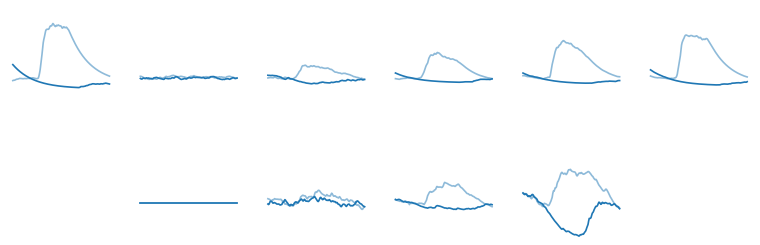

In [7]:
numrows = 5

date = 'Jan19_LargeLong'
plt.figure(figsize=(12, 10), dpi=80)


concatenated_stacks_path = Path('/Volumes/BigFishThry/GoodGregor2P/SpotTricaine/' + date)

AltPath = str(concatenated_stacks_path) + "/"
files = [i for i in os.listdir(AltPath) if "2022" in i]
files.sort()

contours = pd.read_pickle(str(concatenated_stacks_path)+"/" + files[0] + "/rawdata/z_plane0000_trial000_contours.pickle")

ct = '1'

count = 252

c = sns.color_palette("viridis",n_colors = 3*(len(files)))

on_cell = count 
#ymax = max([np.nanmax(LeftTrials_Meta[:,on_cell,:]),np.nanmax(RightTrials_Meta[:,on_cell,:])])
#ymax = 2500
#ymin = min([np.nanmin(LeftTrials_Meta[:,on_cell,:]),np.nanmin(RightTrials_Meta[:,on_cell,:])])
num_experiments = int(RightTrials_Meta.shape[0]/24)
for experiments in range(num_experiments):
    ax = plt.subplot(numrows,num_experiments,experiments+1)
    plt.plot(np.nanmean(LeftTrials_Meta[experiments*24:experiments*24+24,on_cell,:],axis=0),color = sns.color_palette()[0],alpha = 0.5)
    plt.plot(np.nanmean(RightTrials_Meta[experiments*24:experiments*24+24,on_cell,:],axis=0),color = sns.color_palette()[0])

    plt.ylim([ymin,ymax])
    plt.xticks([])
    if experiments == -1:
        for bounds in ['right','top','bottom']:
            right_side = ax.spines[bounds]
            right_side.set_visible(False)
            right_side = ax.spines[bounds]
            right_side.set_visible(False)
    else:
        plt.yticks([])
        for bounds in ['right','top','bottom','left']:
            right_side = ax.spines[bounds]
            right_side.set_visible(False)
            right_side = ax.spines[bounds]
            right_side.set_visible(False)



count = 143

c = sns.color_palette("viridis",n_colors = 3*(len(files)))

on_cell = count 
#ymax = max([np.nanmax(Lifetime_LeftTrials_Meta[:,on_cell,:]),np.nanmax(Lifetime_RightTrials_Meta[:,on_cell,:])])
#ymax = 2500
#ymin = min([np.nanmin(Lifetime_LeftTrials_Meta[:,on_cell,:]),np.nanmin(Lifetime_RightTrials_Meta[:,on_cell,:])])
num_experiments = int(Lifetime_RightTrials_Meta.shape[0]/24)
for experiments in range(num_experiments):
    ax = plt.subplot(numrows,int(RightTrials_Meta.shape[0]/24),int(RightTrials_Meta.shape[0]/24)+experiments+2)
    plt.plot(np.nanmean(Lifetime_LeftTrials_Meta[experiments*24:experiments*24+24,on_cell,:],axis=0),color = sns.color_palette()[0],alpha = 0.5)
    plt.plot(np.nanmean(Lifetime_RightTrials_Meta[experiments*24:experiments*24+24,on_cell,:],axis=0),color = sns.color_palette()[0])

    plt.ylim([ymin,ymax])
    plt.xticks([])
    if experiments == -1:
        for bounds in ['right','top','bottom']:
            right_side = ax.spines[bounds]
            right_side.set_visible(False)
            right_side = ax.spines[bounds]
            right_side.set_visible(False)
    else:
        plt.yticks([])
        for bounds in ['right','top','bottom','left']:
            right_side = ax.spines[bounds]
            right_side.set_visible(False)
            right_side = ax.spines[bounds]
            right_side.set_visible(False)
pl.savefig('Figures/Figure4/RightCellTraces.pdf',bbox_inches='tight') 

## Regional


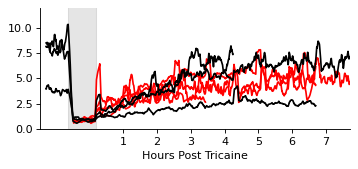

In [94]:
fig, ax = plt.subplots(figsize=(5, 2), dpi=80)
ax.add_patch(patches.Rectangle((2936, -0.0084), 2936, 40, color = 'k', alpha = 0.1))
windowsize = 100
Smoothing = 500
LifePath = '/Volumes/BigFishThry/GlobalAndRegionalTraces/Lifetime/'
Region = '/Global.csv'

for file in os.listdir(LifePath):
    path = LifePath + file

    z = pd.read_csv(path+Region)

    s = z['Mean']
    data = (pd.Series(s)-pd.Series(s).rolling(60).mean())/pd.Series(s).rolling(60).mean()
    upperEnv=data.rolling(window=windowsize).max().shift(int(-windowsize/2))
    plt.plot(np.array(range(len(upperEnv)))+2936,(upperEnv/np.nanmean(upperEnv[:2936])).rolling(Smoothing).mean(),'r')

SpotPath = '/Volumes/BigFishThry/GlobalAndRegionalTraces/Spot/'

for file in os.listdir(SpotPath):
    path = SpotPath + file

    z = pd.read_csv(path+Region)

    s = z['Mean']
    data = (pd.Series(s)-pd.Series(s).rolling(60).mean())/pd.Series(s).rolling(60).mean()
    upperEnv=data.rolling(window=windowsize).max().shift(int(-windowsize/2))
    plt.plot((upperEnv/np.nanmean(upperEnv[2936:2*2936])).rolling(Smoothing).mean(),'k')





ax.set(xlabel = 'Hours Post Tricaine', ylabel = '')
plt.xticks(np.arange(2936*3, 33000, 3600),labels = list(range(1,len(np.arange(2936*3, 33000+3000, 3600)),1)))

ax.set(ylim = [0,12],xlim = [0,33000])

for bounds in ['right','top']:
    right_side = ax.spines[bounds]
    right_side.set_visible(False)
    right_side = ax.spines[bounds]
    right_side.set_visible(False)

plt.savefig('Figures/Figure4/GlobalMulti.pdf', bbox_inches="tight")


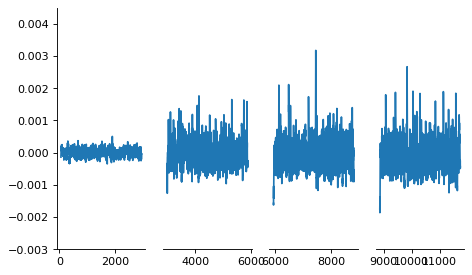

In [5]:
path = '/Volumes/BigFishThry/GlobalAndRegionalTraces/Lifetime/Feb17/'

z = pd.read_csv(path+'Global.csv')
plt.figure(figsize=(10, 4), dpi=80)

s = z['Mean']
for i in range(4):
    ax = plt.subplot(1,6,i+2)
    plt.plot((pd.Series(s)[2936*i:2936*(i+1)]-pd.Series(s)[2936*i:2936*(i+1)].rolling(60).mean())/pd.Series(s).rolling(60).mean())
    ax.set(ylim = [-0.003,0.0045])
    
    
    for bounds in ['right','top']:
        right_side = ax.spines[bounds]
        right_side.set_visible(False)

    if i >0:
        for bounds in ['left','top']:
            right_side = ax.spines[bounds]
            right_side.set_visible(False)
        ax.set(yticks = [])

plt.savefig('Figures/Figure4/GlobalTrace.pdf',bbox_inches='tight') 